In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs


### Sub-sampling

For this demonstration, we search for frogs in the Greater Sydney area and the 5 testing regions found between the start of 2015 to the end of 2019. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [3]:
bboxs=[
    # Evaluation ones
    (144.8,-38.5,145.8,-37.5), 
    (150.7,-33.5,151.7,-32.5), 
    (152.6,-29.0,153.6,-28.0),
    (145.0,-17.7,146.0,-16.7),
    (115.7,-32.5,116.7,-31.5),
    # New ones here
    (148.8, -35.7, 149.8, -34.7),
    (152.3, -30.7, 153.3, -29.7),
    (152.1, -27.3 , 153.1, -26.3),
    (130.8, -12.8, 131.8, -11.8),
    
]
    
# Load in data

frog_datas = []
for bbox in bboxs:
    frog_datas.append(get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2022), bbox=bbox))

In [4]:
target_species = 'Litoria Fallax'

for i, frog_data in enumerate(frog_datas):
    frog_datas[i] = (
        frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        ).reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )
frog_datas[0]

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,1
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,2
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,3
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4
...,...,...,...,...,...,...,...,...,...,...
5289,3130807827,2015-06-02 00:00:00,Australia,Australia,Victoria,-37.566500,145.088590,Crinia Signifera,0,5289
5290,3130905773,2016-11-21 00:00:00,Australia,Australia,Victoria,-38.008890,145.149170,Crinia Signifera,0,5290
5291,3129207916,2017-12-20 00:00:00,Australia,Australia,Victoria,-37.747250,145.085730,Litoria Fallax,1,5291
5292,3130850457,2019-01-01 00:00:00,Australia,Australia,Victoria,-37.924810,145.556440,Crinia Signifera,0,5292


#### Spatial sampling

While we have restricted our analysis to Greater Sydney for this demonstration,  you are encouraged to explore different areas to assist in creating a SDM that is representative of the habitat of litoria fallax. You could even use the entire training set, but keep in mind that loading in large areas may be quite computationally expensive. We recommend loading data in chunks that are a similar size to the bounding box we defined above.

#### Temporal sampling

Another area that may assist you in developing your SDM is the time dimension of the data. Each occurrence has an "eventDate" attribute, and the terraclimate data is taken monthly. You may want to consider whether more closely matching occurrences to timely data will improve your model. Another idea is to pool the data into larger time chunks like we have done in this notebook. This could involve extending our approach of binning the data in 5 year intervals to include occurrence data for 2010-2015, 2005-2009, etc. Either approach would allow you to utilise more of the training data which could greatly assist your SDM training.

### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will use the other species, crinia signifera - the common eastern froglet, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera).

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [5]:
def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = ds.groupby('time.month').mean(dim='time')
    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_month = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    sets = [
        ds_month.sel(month=month
                    ).rename(
            {var: ' '.join((str(month), var)) for var in list(ds_month.keys())}
        ).drop_vars('month')
        for month in ds_month.month.values
    ]
    ds = xr.merge(sets).to_array().rename(variable='band')
    
    return ds

In [6]:
# Date range to take
time_slice = ('2015-01-01','2022-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

interp_dims = (512, 512)

weather_datas = []
for bbox in bboxs:
    weather_datas.append(get_terraclimate(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=True))

Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image


Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

The spatial distribution of the four variables are displayed below.

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [7]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
model_datas = []
for frog_data, weather_data in zip(frog_datas, weather_datas):    
    model_datas.append(join_frogs(frog_data, weather_data))

model_data = pd.concat(model_datas).dropna()
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,7 tmax,7 tmin,8 ppt,8 soil,8 tmax,8 tmin,9 ppt,9 soil,9 tmax,9 tmin
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,...,13.700002,5.940001,81.199997,114.199997,14.120001,6.080003,72.800003,116.000000,16.540001,7.180002
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,1,...,13.540001,5.660004,99.199997,183.600006,13.820002,5.560004,87.599998,183.600006,16.080000,6.600001
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,2,...,13.760004,5.140001,87.400002,149.600006,14.260000,5.379999,82.599998,159.000000,16.620001,6.720000
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,3,...,13.480001,5.480000,90.800003,124.400002,14.000002,5.480002,82.599998,119.199997,16.480000,6.560002
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,4,...,14.040001,6.360001,69.000000,52.799999,14.720001,6.640002,57.799999,49.799999,17.160002,7.740001


In [8]:
len(model_data)

39572

In [9]:
model_data.groupby('occurrenceStatus').count()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,key,1 ppt,...,7 tmax,7 tmin,8 ppt,8 soil,8 tmax,8 tmin,9 ppt,9 soil,9 tmax,9 tmin
occurrenceStatus,,,,,,,,,,,,,,,,,,,,,
0,25733,25733,25733,25733,25733,25733,25733,25733,25733,25733,...,25733,25733,25733,25733,25733,25733,25733,25733,25733,25733
1,13839,13839,13839,13839,13839,13839,13839,13839,13839,13839,...,13839,13839,13839,13839,13839,13839,13839,13839,13839,13839


## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [10]:
from sklearn.svm import SVC

In [11]:
full_model = SVC(probability=True, class_weight={0: 13839/25733})
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

SVC(class_weight={0: 0.5377919403101077}, probability=True)

### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [12]:
predictions = full_model.predict(X)

In [13]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 


In [14]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [ ]:
# Calculate probability for each pixel point 

resultant_images = []
for weather_data in weather_datas:
    resultant_images.append(predict_frogs(weather_data, full_model))

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook only took naive approaches to address this. The model evaluation metrics are only as good as the data used to evaluate it, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance. 

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation. You can even code your own if you think it will assist you in evaluating your model.


In [15]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.76
Accuracy: 0.79


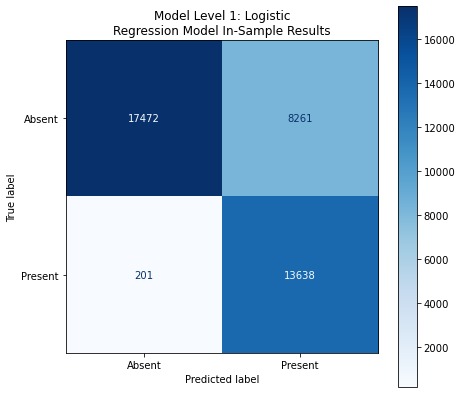

In [16]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

In [ ]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)

In [ ]:
for frog_data, resultant_image in zip(frog_datas, resultant_images):
    plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results")

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


In [17]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10


KeyError: '[6732, 7066, 7248, 7484, 7837, 7981, 8112, 8133, 8337, 8600, 8772, 11798, 12807, 13056, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13081, 13082, 13083, 13084, 13085, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13121, 13123, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 13136, 13137, 13138, 13139, 13140, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13185, 13186, 13187, 13188, 13190, 13191, 13192, 13193, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13203, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13239, 13240, 13241, 13244, 13246, 13247, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13259, 13260, 13261, 13262, 13263, 13264, 13265, 13266, 13267, 13270, 13271, 13272, 13273, 13275, 13276, 13277, 13279, 13280, 13281, 13282, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13322, 13323, 13324, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13360, 13361, 13362, 13363, 13364, 13365, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13388, 13389, 13390, 13391, 13392, 13393, 13395, 13396, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13410, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13421, 13422, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13435, 13436, 13437, 13438, 13439, 13440, 13441, 13442, 13444, 13446, 13447, 13448, 13449, 13450, 13451, 13454, 13455, 13456, 13457, 13458, 13459, 13460, 13461, 13462, 13463, 13465, 13466, 13468, 13469, 13470, 13471, 13472, 13474, 13475, 13476, 13477, 13478, 13480, 13481, 13482, 13483, 13484, 13485, 13487, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13495, 13497, 13498, 13499, 13500, 13501, 13502, 13503, 13504, 13505, 13506, 13507, 13508, 13510, 13511, 13512, 13513, 13514, 13515, 13516, 13518, 13519, 13520, 13521, 13522, 13523, 13528, 13529, 13530, 13531, 13532, 13533, 13534, 13535, 13536, 13537, 13538, 13539, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547, 13548, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13558, 13560, 13561, 13562, 13563, 13564, 13566, 13567, 13568, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13581, 13582, 13583, 13584, 13585, 13586, 13587, 13588, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13596, 13597, 13598, 13599, 13600, 13601, 13602, 13603, 13604, 13605, 13607, 13608, 13609, 13610, 13611, 13612, 13613, 13614, 13615, 13616, 13618, 13619, 13620, 13621, 13622, 13623, 13624, 13625, 13626, 13627, 13628, 13629, 13630, 13633, 13634, 13635, 13636, 13637, 13639, 13640, 13641, 13642, 13643, 13644, 13645, 13646, 13647, 13648, 13649, 13651, 13652, 13653, 13654, 13655, 13656, 13658, 13659, 13660, 13661, 13662, 13663, 13664, 13666, 13668, 13669, 13670, 13671, 13672, 13674, 13675, 13676, 13677, 13678, 13679, 13680, 13681, 13682, 13683, 13684, 13685, 13687, 13688, 13690, 13691, 13692, 13693, 13694, 13695, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704, 13705, 13708, 13709, 13710, 13711, 13712, 13713, 13714, 13716, 13717, 13718, 13719, 13721, 13722, 13723, 13724, 13725, 13726, 13727, 13728, 13729, 13730, 13731, 13732, 13733, 13734, 13735, 13737, 13738, 13739, 13740, 13743, 13744, 13746, 13747, 13748, 13749, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758, 13759, 13761, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13771, 13772, 13773, 13774, 13775, 13776, 13778, 13779, 13780, 13781, 13782, 13785, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13794, 13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812, 13813, 13815, 13816, 13817, 13818, 13820, 13821, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13832, 13833, 13834, 13835, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13846, 13847, 13848, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867, 13868, 13869, 13870, 13871, 13872, 13873, 13875, 13876, 13877, 13878, 13880, 13881, 13882, 13883, 13884, 13886, 13887, 13888, 13889, 13890, 13891, 13892, 13893, 13894, 13895, 13898, 13899, 13900, 13901, 13902, 13903, 13904, 13905, 13907, 13908, 13909, 13910, 13911, 13912, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13922, 13923, 13924, 13925, 13926, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13956, 13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970, 13971, 13972, 13973, 13974, 13975, 13976, 13977, 13978, 13980, 13981, 13982, 13983, 13984, 13985, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021, 14022, 14023, 14024, 14025, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033, 14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041, 14042, 14043, 14044, 14046, 14047, 14048, 14050, 14051, 14052, 14053, 14055, 14056, 14061, 14062, 14063, 14064, 14065, 14066, 14067, 14068, 14069, 14070, 14071, 14072, 14073, 14074, 14075, 14076, 14077, 14078, 14079, 14080, 14081, 14082, 14083, 14084, 14086, 14087, 14088, 14089, 14090, 14091, 14093, 14095, 14096, 14097, 14098, 14099, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 14109, 14110, 14111, 14112, 14113, 14114, 14115, 14116, 14118, 14119, 14120, 14121, 14122, 14124, 14125, 14126, 14128, 14129, 14130, 14131, 14132, 14133, 14136, 14137, 14138, 14140, 14141, 14142, 14143, 14144, 14145, 14146, 14147, 14148, 14149, 14150, 14151, 14152, 14153, 14154, 14155, 14156, 14157, 14158, 14160, 14161, 14162, 14163, 14164, 14166, 14168, 14169, 14170, 14172, 14173, 14174, 14175, 14176, 14177, 14178, 14179, 14180, 14181, 14182, 14185, 14186, 14187, 14188, 14189, 14190, 14191, 14192, 14193, 14194, 14195, 14196, 14197, 14198, 14199, 14200, 14201, 14203, 14204, 14205, 14206, 14207, 14208, 14209, 14210, 14211, 14213, 14214, 14215, 14217, 14218, 14219, 14220, 14221, 14222, 14223, 14224, 14226, 14227, 14228, 14230, 14231, 14232, 14233, 14234, 14235, 14236, 14237, 14238, 14239, 14240, 14241, 14242, 14243, 14244, 14245, 14246, 14247, 14248, 14249, 14250, 14251, 14252, 14253, 14254, 14255, 14256, 14257, 14259, 14260, 14261, 14262, 14263, 14264, 14265, 14266, 14267, 14268, 14269, 14270, 14271, 14273, 14274, 14275, 14276, 14277, 14279, 14280, 14281, 14282, 14283, 14285, 14286, 14287, 14288, 14289, 14290, 14291, 14292, 14293, 14294, 14295, 14296, 14297, 14298, 14300, 14301, 14302, 14303, 14304, 14306, 14307, 14308, 14309, 14310, 14311, 14312, 14313, 14314, 14315, 14316, 14317, 14318, 14319, 14320, 14321, 14322, 14323, 14324, 14325, 14326, 14327, 14329, 14331, 14332, 14333, 14334, 14335, 14336, 14337, 14338, 14339, 14341, 14343, 14344, 14346, 14347, 14348, 14349, 14350, 14351, 14352, 14353, 14354, 14355, 14356, 14357, 14358, 14359, 14360, 14361, 14362, 14363, 14364, 14365, 14367, 14368, 14369, 14370, 14371, 14372, 14373, 14375, 14376, 14377, 14378, 14379, 14380, 14381, 14382, 14384, 14385, 14386, 14387, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14403, 14404, 14405, 14406, 14407, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14437, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445, 14446, 14448, 14449, 14450, 14451, 14452, 14453, 14454, 14455, 14456, 14457, 14458, 14459, 14460, 14461, 14463, 14464, 14465, 14466, 14467, 14468, 14469, 14470, 14471, 14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14486, 14488, 14489, 14490, 14491, 14492, 14493, 14494, 14495, 14497, 14498, 14499, 14501, 14503, 14504, 14505, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14516, 14517, 14518, 14519, 14521, 14522, 14523, 14524, 14525, 14529, 14530, 14532, 14533, 14534, 14535, 14536, 14537, 14538, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14551, 14552, 14553, 14554, 14555, 14557, 14558, 14559, 14560, 14561, 14562, 14563, 14564, 14565, 14566, 14567, 14568, 14569, 14570, 14571, 14572, 14573, 14574, 14575, 14576, 14577, 14578, 14579, 14580, 14581, 14582, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14601, 14602, 14603, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14615, 14616, 14619, 14620, 14621, 14622, 14623, 14624, 14625, 14626, 14627, 14628, 14629, 14630, 14632, 14633, 14634, 14636, 14637, 14638, 14640, 14642, 14643, 14644, 14645, 14646, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731, 14732, 14733, 14734, 14735, 14736, 14738, 14739, 14740, 14741, 14742, 14743, 14745, 14746, 14747, 14748, 14749, 14750, 14751, 14752, 14753, 14754, 14755, 14756, 14757, 14758, 14759, 14760, 14761, 14762, 14763, 14766, 14767, 14768, 14769, 14770, 14771, 14773, 14774, 14775, 14776, 14777, 14778, 14779, 14781, 14782, 14783, 14785, 14786, 14787, 14788, 14789, 14790, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14802, 14803, 14804, 14805, 14806, 14807, 14808, 14809, 14810, 14812, 14813, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 14833, 14834, 14835, 14837, 14838, 14839, 14840, 14841, 14843, 14844, 14845, 14846, 14847, 14848, 14849, 14850, 14851, 14852, 14853, 14854, 14855, 14856, 14857, 14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867, 14868, 14869, 14870, 14871, 14872, 14874, 14875, 14876, 14877, 14879, 14880, 14881, 14882, 14884, 14885, 14886, 14887, 14888, 14889, 14890, 14891, 14892, 14893, 14894, 14895, 14896, 14897, 14898, 14900, 14901, 14902, 14903, 14904, 14905, 14906, 14907, 14908, 14909, 14910, 14911, 14912, 14913, 14914, 14915, 14916, 14917, 14918, 14919, 14921, 14922, 14923, 14924, 14925, 14926, 14927, 14928, 14929, 14930, 14931, 14932, 14933, 14934, 14935, 14936, 14937, 14938, 14939, 14940, 14941, 14942, 14943, 14944, 14945, 14946, 14949, 14950, 14951, 14952, 14953, 14954, 14955, 14956, 14957, 14958, 14959, 14960, 14961, 14962, 14963, 14964, 14965, 14966, 14967, 14968, 14969, 14970, 14971, 14972, 14973, 14974, 14975, 14976, 14977, 14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986, 14987, 14988, 14989, 14990, 14991, 14992, 14993, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15012, 15013, 15014, 15015, 15017, 15018, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027, 15028, 15030, 15031, 15033, 15034, 15035, 15036, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045, 15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15057, 15058, 15059, 15060, 15061, 15062, 15063, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077, 15079, 15080, 15082, 15083, 15084, 15085, 15086, 15088, 15090, 15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099, 15100, 15101, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15111, 15112, 15113, 15115, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126, 15127, 15128, 15129, 15130, 15131, 15132, 15133, 15134, 15135, 15136, 15137, 15138, 15139, 15140, 15141, 15142, 15143, 15144, 15145, 15147, 15149, 15150, 15151, 15152, 15153, 15154, 15155, 15156, 15157, 15158, 15159, 15160, 15161, 15162, 15163, 15165, 15167, 15168, 15169, 15170, 15171, 15172, 15173, 15175, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15185, 15186, 15187, 15188, 15189, 15190, 15191, 15192, 15193, 15194, 15195, 15196, 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15214, 15216, 15219, 15220, 15221, 15223, 15224, 15225, 15226, 15227, 15228, 15229, 15230, 15231, 15232, 15234, 15235, 15236, 15237, 15238, 15239, 15240, 15241, 15242, 15244, 15245, 15246, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15271, 15272, 15273, 15274, 15275, 15276, 15277, 15278, 15279, 15280, 15281, 15282, 15283, 15284, 15285, 15286, 15287, 15288, 15290, 15291, 15292, 15293, 15294, 15296, 15297, 15298, 15299, 15300, 15301, 15302, 15303, 15304, 15305, 15306, 15307, 15308, 15309, 15310, 15311, 15312, 15313, 15314, 15315, 15316, 15317, 15318, 15319, 15320, 15321, 15322, 15324, 15325, 15326, 15327, 15328, 15329, 15330, 15331, 15332, 15333, 15334, 15335, 15336, 15339, 15341, 15342, 15343, 15346, 15347, 15348, 15350, 15351, 15352, 15353, 15354, 15355, 15356, 15357, 15358, 15359, 15360, 15361, 15362, 15363, 15364, 15366, 15367, 15368, 15369, 15370, 15371, 15373, 15374, 15375, 15376, 15377, 15378, 15379, 15381, 15382, 15383, 15385, 15386, 15387, 15388, 15389, 15390, 15391, 15392, 15393, 15394, 15395, 15396, 15397, 15398, 15399, 15400, 15401, 15402, 15403, 15404, 15405, 15406, 15407, 15408, 15409, 15410, 15411, 15412, 15413, 15414, 15416, 15417, 15418, 15419, 15420, 15421, 15422, 15423, 15424, 15425, 15426, 15427, 15428, 15430, 15432, 15433, 15435, 15436, 15437, 15440, 15441, 15442, 15443, 15444, 15445, 15446, 15447, 15448, 15450, 15451, 15452, 15454, 15456, 15457, 15458, 15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467, 15468, 15469, 15470, 15471, 15472, 15473, 15475, 15476, 15477, 15478, 15479, 15480, 15481, 15482, 15483, 15484, 15486, 15487, 15488, 15489, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 15497, 15498, 15499, 15500, 15501, 15502, 15503, 15504, 15505, 15506, 15507, 15508, 15509, 15510, 15511, 15512, 15513, 15514, 15515, 15516, 15517, 15518, 15519, 15520, 15521, 15522, 15523, 15524, 15525, 15526, 15527, 15529, 15530, 15531, 15532, 15533, 15534, 15535, 15536, 15537, 15538, 15539, 15540, 15541, 15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15554, 15555, 15556, 15557, 15558, 15559, 15560, 15561, 15563, 15564, 15565, 15566, 15568, 15569, 15570, 15571, 15573, 15574, 15576, 15577, 15578, 15579, 15580, 15581, 15582, 15583, 15584, 15585, 15586, 15587, 15588, 15589, 15591, 15592, 15594, 15595, 15596, 15597, 15598, 15599, 15601, 15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630, 15632, 15633, 15634, 15635, 15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15679, 15680, 15681, 15682, 15683, 15685, 15686, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15735, 15736, 15737, 15738, 15739, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15747, 15748, 15749, 15750, 15751, 15752, 15753, 15754, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15763, 15764, 15765, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15776, 15777, 15778, 15779, 15781, 15783, 15784, 15785, 15786, 15787, 15788, 15789, 15790, 15791, 15792, 15793, 15794, 15795, 15796, 15797, 15798, 15799, 15801, 15802, 15803, 15804, 15805, 15806, 15807, 15808, 15809, 15811, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15822, 15823, 15824, 15825, 15826, 15827, 15828, 15829, 15830, 15831, 15832, 15833, 15834, 15835, 15836, 15839, 15840, 15842, 15843, 15844, 15845, 15847, 15848, 15849, 15850, 15851, 15852, 15855, 15856, 15857, 15858, 15859, 15861, 15862, 15863, 15865, 15866, 15867, 15869, 15870, 15871, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15881, 15882, 15883, 15884, 15886, 15887, 15888, 15889, 15890, 15891, 15893, 15894, 15895, 15896, 15897, 15898, 15902, 15903, 15904, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 15915, 15916, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15978, 15979, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15991, 15992, 15993, 15994, 15995, 15996, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16026, 16027, 16028, 16029, 16030, 16031, 16032, 16033, 16034, 16035, 16036, 16038, 16039, 16040, 16041, 16042, 16043, 16044, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16076, 16078, 16079, 16080, 16081, 16082, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16092, 16093, 16094, 16095, 16096, 16097, 16098, 16099, 16100, 16101, 16102, 16103, 16104, 16105, 16106, 16107, 16108, 16109, 16110, 16111, 16112, 16113, 16114, 16116, 16117, 16118, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16127, 16128, 16130, 16131, 16132, 16133, 16134, 16136, 16137, 16138, 16140, 16141, 16142, 16143, 16144, 16145, 16146, 16147, 16148, 16149, 16150, 16151, 16153, 16154, 16155, 16156, 16157, 16159, 16160, 16161, 16163, 16164, 16166, 16167, 16168, 16169, 16170, 16171, 16173, 16174, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185, 16186, 16187, 16188, 16189, 16190, 16191, 16192, 16193, 16194, 16195, 16197, 16198, 16199, 16200, 16201, 16202, 16203, 16204, 16206, 16208, 16210, 16211, 16212, 16214, 16215, 16216, 16217, 16218, 16219, 16220, 16221, 16222, 16224, 16225, 16226, 16227, 16228, 16229, 16230, 16231, 16232, 16233, 16234, 16235, 16236, 16237, 16238, 16239, 16240, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16248, 16249, 16250, 16251, 16252, 16253, 16255, 16256, 16257, 16258, 16259, 16261, 16262, 16263, 16264, 16265, 16266, 16267, 16268, 16269, 16270, 16271, 16272, 16273, 16274, 16275, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289, 16290, 16291, 16292, 16293, 16294, 16295, 16297, 16298, 16301, 16303, 16304, 16305, 16306, 16308, 16310, 16311, 16312, 16313, 16314, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16324, 16325, 16326, 16327, 16329, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 16340, 16341, 16342, 16343, 16344, 16345, 16346, 16347, 16349, 16350, 16351, 16352, 16353, 16354, 16355, 16356, 16357, 16359, 16360, 16361, 16362, 16363, 16364, 16365, 16366, 16367, 16368, 16369, 16370, 16371, 16372, 16373, 16374, 16375, 16376, 16377, 16380, 16381, 16382, 16383, 16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16407, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16450, 16451, 16452, 16453, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16462, 16463, 16464, 16465, 16466, 16467, 16468, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16480, 16481, 16482, 16485, 16486, 16487, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16497, 16498, 16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16545, 16546, 16547, 16548, 16549, 16551, 16552, 16553, 16555, 16556, 16557, 16558, 16560, 16561, 16562, 16563, 16565, 16566, 16567, 16568, 16569, 16570, 16571, 16572, 16573, 16574, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16586, 16589, 16590, 16591, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16600, 16601, 16602, 16603, 16604, 16605, 16606, 16607, 16608, 16610, 16611, 16612, 16613, 16614, 16615, 16617, 16618, 16619, 16621, 16622, 16623, 16624, 16625, 16626, 16627, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16636, 16637, 16638, 16639, 16640, 16642, 16643, 16644, 16645, 16646, 16648, 16649, 16650, 16651, 16653, 16654, 16655, 16656, 16657, 16658, 16659, 16660, 16661, 16663, 16664, 16665, 16666, 16667, 16668, 16670, 16671, 16672, 16673, 16674, 16675, 16676, 16677, 16679, 16680, 16681, 16682, 16684, 16686, 16688, 16690, 16691, 16692, 16693, 16694, 16695, 16696, 16697, 16698, 16699, 16700, 16701, 16702, 16703, 16704, 16705, 16706, 16707, 16708, 16710, 16711, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16719, 16720, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752, 16753, 16754, 16755, 16756, 16757, 16758, 16759, 16761, 16762, 16763, 16764, 16765, 16766, 16767, 16768, 16769, 16771, 16772, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 16780, 16782, 16783, 16785, 16787, 16788, 16789, 16790, 16791, 16793, 16794, 16795, 16796, 16797, 16798, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16813, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16826, 16827, 16828, 16829, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16840, 16841, 16842, 16843, 16844, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16861, 16862, 16864, 16865, 16866, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16881, 16882, 16883, 16884, 16885, 16886, 16889, 16890, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16910, 16911, 16912, 16913, 16914, 16916, 16917, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16950, 16952, 16953, 16954, 16955, 16956, 16958, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16973, 16974, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16987, 16988, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 16998, 16999, 17000, 17002, 17003, 17004, 17005, 17006, 17007, 17008, 17009, 17011, 17012, 17013, 17014, 17015, 17016, 17017, 17018, 17019, 17020, 17021, 17022, 17023, 17024, 17025, 17026, 17027, 17028, 17029, 17030, 17031, 17032, 17033, 17035, 17036, 17037, 17038, 17039, 17042, 17043, 17044, 17045, 17046, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17056, 17057, 17058, 17061, 17063, 17064, 17065, 17066, 17067, 17071, 17072, 17073, 17075, 17076, 17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17089, 17090, 17091, 17092, 17093, 17094, 17095, 17096, 17097, 17098, 17099, 17101, 17102, 17103, 17104, 17105, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17139, 17140, 17142, 17143, 17145, 17147, 17148, 17149, 17150, 17151, 17152, 17153, 17154, 17155, 17156, 17157, 17158, 17159, 17160, 17161, 17162, 17163, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17188, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17218, 17219, 17220, 17221, 17222, 17223, 17225, 17226, 17227, 17228, 17229, 17231, 17232, 17233, 17234, 17235, 17237, 17238, 17239, 17240, 17241, 17242, 17243, 17244, 17245, 17247, 17249, 17250, 17251, 17252, 17253, 17254, 17255, 17257, 17258, 17259, 17260, 17261, 17262, 17264, 17265, 17266, 17267, 17268, 17269, 17270, 17271, 17272, 17273, 17275, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17298, 17299, 17300, 17301, 17302, 17303, 17304, 17305, 17306, 17307, 17308, 17309, 17310, 17311, 17312, 17313, 17314, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17322, 17323, 17325, 17326, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17338, 17339, 17340, 17341, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350, 17354, 17356, 17358, 17359, 17361, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 17370, 17371, 17372, 17373, 17374, 17375, 17376, 17377, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17390, 17391, 17393, 17394, 17396, 17397, 17398, 17399, 17400, 17401, 17402, 17403, 17404, 17406, 17407, 17408, 17409, 17410, 17412, 17413, 17414, 17415, 17416, 17417, 17418, 17419, 17420, 17421, 17422, 17425, 17426, 17427, 17428, 17429, 17430, 17431, 17433, 17434, 17435, 17436, 17437, 17438, 17439, 17440, 17441, 17442, 17443, 17444, 17445, 17446, 17447, 17448, 17449, 17450, 17451, 17452, 17453, 17455, 17456, 17457, 17458, 17459, 17460, 17461, 17462, 17464, 17465, 17466, 17468, 17469, 17470, 17471, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17481, 17482, 17483, 17485, 17486, 17487, 17488, 17490, 17491, 17492, 17493, 17494, 17495, 17496, 17497, 17498, 17499, 17500, 17501, 17502, 17503, 17504, 17505, 17506, 17507, 17508, 17509, 17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17520, 17521, 17522, 17523, 17524, 17525, 17527, 17529, 17530, 17531, 17533, 17534, 17536, 17537, 17538, 17540, 17541, 17543, 17544, 17545, 17546, 17548, 17549, 17550, 17552, 17553, 17554, 17555, 17557, 17558, 17559, 17560, 17562, 17563, 17564, 17565, 17566, 17567, 17568, 17569, 17570, 17571, 17572, 17573, 17574, 17575, 17576, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584, 17585, 17586, 17587, 17588, 17589, 17590, 17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600, 17601, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17611, 17612, 17613, 17614, 17615, 17616, 17617, 17618, 17619, 17620, 17621, 17622, 17623, 17624, 17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17640, 17642, 17643, 17644, 17645, 17646, 17647, 17648, 17649, 17650, 17651, 17653, 17654, 17655, 17656, 17657, 17658, 17659, 17660, 17661, 17662, 17663, 17664, 17665, 17666, 17667, 17668, 17669, 17670, 17671, 17672, 17673, 17674, 17675, 17676, 17677, 17678, 17679, 17680, 17681, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690, 17692, 17693, 17694, 17695, 17696, 17697, 17699, 17700, 17701, 17702, 17703, 17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17712, 17713, 17714, 17715, 17716, 17717, 17719, 17720, 17721, 17722, 17723, 17724, 17725, 17726, 17727, 17728, 17729, 17730, 17731, 17732, 17733, 17734, 17735, 17737, 17738, 17739, 17740, 17741, 17742, 17743, 17744, 17745, 17746, 17747, 17748, 17749, 17751, 17753, 17755, 17756, 17757, 17758, 17759, 17760, 17762, 17763, 17764, 17765, 17766, 17767, 17768, 17769, 17771, 17773, 17774, 17775, 17776, 17777, 17778, 17779, 17780, 17781, 17782, 17783, 17784, 17785, 17786, 17787, 17789, 17790, 17791, 17793, 17794, 17796, 17797, 17798, 17800, 17801, 17802, 17803, 17804, 17806, 17807, 17808, 17809, 17810, 17811, 17812, 17813, 17814, 17815, 17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17841, 17842, 17843, 17844, 17845, 17847, 17848, 17849, 17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858, 17859, 17860, 17862, 17863, 17864, 17865, 17866, 17867, 17868, 17871, 17873, 17874, 17875, 17876, 17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17888, 17889, 17890, 17891, 17892, 17893, 17894, 17896, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17907, 17908, 17910, 17911, 17912, 17913, 17915, 17916, 17917, 17918, 17920, 17921, 17922, 17923, 17924, 17925, 17926, 17927, 17928, 17929, 17930, 17931, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17942, 17943, 17944, 17945, 17946, 17947, 17948, 17949, 17950, 17951, 17952, 17953, 17955, 17956, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17975, 17976, 17977, 17978, 17979, 17981, 17982, 17984, 17985, 17986, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998, 17999, 18000, 18002, 18003, 18004, 18006, 18007, 18008, 18009, 18010, 18011, 18012, 18014, 18015, 18016, 18017, 18018, 18019, 18020, 18021, 18022, 18023, 18025, 18026, 18027, 18028, 18029, 18030, 18031, 18032, 18033, 18034, 18035, 18037, 18039, 18041, 18042, 18043, 18044, 18045, 18046, 18047, 18048, 18049, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18064, 18065, 18066, 18067, 18068, 18069, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18078, 18079, 18080, 18081, 18082, 18083, 18084, 18085, 18087, 18088, 18089, 18091, 18092, 18093, 18094, 18095, 18096, 18097, 18098, 18099, 18100, 18101, 18102, 18104, 18105, 18109, 18110, 18111, 18112, 18115, 18116, 18117, 18118, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128, 18129, 18130, 18131, 18132, 18133, 18134, 18135, 18136, 18137, 18138, 18139, 18140, 18142, 18143, 18144, 18145, 18146, 18148, 18149, 18150, 18151, 18152, 18153, 18154, 18155, 18156, 18157, 18158, 18159, 18160, 18161, 18163, 18164, 18165, 18166, 18167, 18168, 18169, 18170, 18171, 18172, 18174, 18175, 18176, 18177, 18178, 18179, 18180, 18181, 18182, 18183, 18184, 18185, 18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18199, 18200, 18203, 18204, 18205, 18206, 18209, 18210, 18211, 18212, 18213, 18214, 18215, 18216, 18217, 18218, 18219, 18220, 18222, 18223, 18224, 18225, 18226, 18227, 18228, 18229, 18230, 18231, 18232, 18233, 18234, 18235, 18237, 18238, 18239, 18241, 18242, 18243, 18244, 18245, 18246, 18247, 18249, 18250, 18251, 18252, 18253, 18254, 18255, 18256, 18257, 18258, 18259, 18260, 18261, 18262, 18263, 18265, 18266, 18267, 18268, 18269, 18270, 18271, 18272, 18273, 18274, 18275, 18276, 18279, 18281, 18282, 18283, 18284, 18285, 18286, 18287, 18288, 18289, 18291, 18292, 18293, 18294, 18295, 18296, 18297, 18298, 18300, 18301, 18302, 18303, 18304, 18305, 18306, 18307, 18309, 18310, 18311, 18312, 18313, 18314, 18315, 18316, 18317, 18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326, 18327, 18328, 18329, 18330, 18332, 18333, 18334, 18335, 18336, 18337, 18338, 18340, 18341, 18342, 18343, 18344, 18345, 18346, 18347, 18348, 18349, 18350, 18351, 18353, 18354, 18355, 18356, 18357, 18358, 18359, 18360, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18370, 18372, 18374, 18375, 18376, 18377, 18378, 18379, 18380, 18381, 18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390, 18391, 18392, 18393, 18394, 18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403, 18405, 18406, 18407, 18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18421, 18422, 18423, 18424, 18426, 18428, 18429, 18430, 18431, 18432, 18433, 18434, 18435, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18447, 18449, 18450, 18451, 18452, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18474, 18475, 18477, 18478, 18479, 18480, 18481, 18482, 18483, 18485, 18487, 18488, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18503, 18504, 18505, 18506, 18507, 18508, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18569, 18570, 18571, 18572, 18574, 18575, 18576, 18577, 18579, 18580, 18582, 18583, 18584, 18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 18597, 18598, 18599, 18600, 18601, 18602, 18604, 18605, 18606, 18607, 18608, 18609, 18610, 18611, 18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620, 18621, 18622, 18623, 18625, 18626, 18627, 18628, 18629, 18630, 18631, 18632, 18634, 18635, 18636, 18637, 18638, 18639, 18640, 18641, 18642, 18643, 18644, 18645, 18647, 18648, 18649, 18650, 18651, 18652, 18653, 18654, 18655, 18656, 18657, 18658, 18659, 18660, 18661, 18662, 18663, 18664, 18666, 18667, 18669, 18670, 18671, 18672, 18673, 18674, 18675, 18676, 18677, 18679, 18681, 18682, 18683, 18684, 18685, 18687, 18688, 18689, 18690, 18691, 18692, 18693, 18694, 18695, 18696, 18697, 18698, 18699, 18700, 18703, 18704, 18705, 18706, 18707, 18708, 18709, 18710, 18711, 18712, 18713, 18714, 18715, 18716, 18717, 18718, 18719, 18720, 18721, 18722, 18723, 18724, 18725, 18726, 18727, 18728, 18729, 18730, 18732, 18733, 18734, 18735, 18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745, 18746, 18747, 18748, 18749, 18750, 18751, 18752, 18753, 18754, 18755, 18756, 18757, 18758, 18759, 18760, 18761, 18763, 18764, 18765, 18766, 18767, 18768, 18769, 18770, 18771, 18772, 18773, 18774, 18775, 18776, 18777, 18778, 18779, 18780, 18781, 18782, 18783, 18784, 18785, 18786, 18787, 18788, 18789, 18790, 18791, 18792, 18793, 18794, 18795, 18796, 18797, 18798, 18799, 18800, 18801, 18802, 18803, 18804, 18805, 18806, 18807, 18808, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18819, 18820, 18821, 18823, 18824, 18825, 18826, 18827, 18828, 18829, 18830, 18831, 18832, 18833, 18834, 18835, 18836, 18839, 18840, 18841, 18842, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18874, 18875, 18876, 18877, 18880, 18881, 18882, 18883, 18884, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18899, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18907, 18908, 18910, 18912, 18915, 18916, 18917, 18918, 18919, 18920, 18921, 18922, 18923, 18924, 18925, 18926, 18927, 18928, 18929, 18931, 18932, 18933, 18934, 18935, 18936, 18937, 18939, 18940, 18941, 18942, 18943, 18944, 18945, 18946, 18947, 18948, 18949, 18950, 18951, 18953, 18954, 18955, 18956, 18957, 18958, 18959, 18960, 18961, 18962, 18963, 18964, 18965, 18967, 18969, 18970, 18971, 18972, 18974, 18976, 18977, 18978, 18979, 18980, 18981, 18982, 18983, 18984, 18985, 18986, 18987, 18988, 18989, 18990, 18991, 18993, 18994, 18995, 18996, 18997, 18998, 18999, 19001, 19002, 19003, 19004, 19005, 19006, 19007, 19008, 19009, 19010, 19011, 19012, 19013, 19014, 19015, 19016, 19017, 19018, 19020, 19022, 19023, 19024, 19025, 19026, 19027, 19028, 19029, 19030, 19031, 19032, 19035, 19036, 19037, 19038, 19039, 19040, 19041, 19042, 19043, 19044, 19045, 19047, 19048, 19050, 19051, 19052, 19053, 19055, 19056, 19058, 19059, 19060, 19061, 19062, 19063, 19064, 19065, 19066, 19067, 19069, 19070, 19071, 19072, 19073, 19074, 19075, 19076, 19077, 19078, 19080, 19081, 19082, 19083, 19084, 19085, 19086, 19087, 19089, 19090, 19091, 19092, 19093, 19094, 19097, 19098, 19099, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19108, 19109, 19110, 19111, 19112, 19113, 19114, 19115, 19116, 19117, 19119, 19120, 19121, 19122, 19124, 19125, 19126, 19127, 19128, 19129, 19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138, 19140, 19141, 19143, 19144, 19145, 19146, 19147, 19148, 19149, 19150, 19151, 19152, 19154, 19155, 19156, 19157, 19158, 19159, 19160, 19161, 19162, 19163, 19164, 19165, 19166, 19167, 19168, 19169, 19170, 19171, 19172, 19174, 19175, 19176, 19177, 19178, 19179, 19180, 19181, 19182, 19183, 19184, 19185, 19186, 19189, 19190, 19191, 19192, 19193, 19194, 19195, 19196, 19197, 19198, 19199, 19200, 19201, 19202, 19203, 19204, 19205, 19206, 19207, 19208, 19209, 19210, 19211, 19213, 19215, 19216, 19217, 19218, 19219, 19221, 19222, 19223, 19224, 19225, 19226, 19228, 19229, 19230, 19231, 19232, 19233, 19234, 19235, 19237, 19238, 19239, 19240, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19259, 19260, 19261, 19262, 19264, 19266, 19267, 19268, 19271, 19272, 19274, 19275, 19276, 19277, 19278, 19279, 19280, 19281, 19282, 19283, 19285, 19286, 19287, 19288, 19289, 19290, 19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300, 19303, 19304, 19305, 19306, 19307, 19308, 19309, 19311, 19312, 19313, 19314, 19315, 19316, 19317, 19318, 19319, 19320, 19321, 19322, 19324, 19325, 19326, 19327, 19328, 19330, 19331, 19332, 19333, 19334, 19335, 19336, 19338, 19339, 19341, 19342, 19345, 19346, 19347, 19348, 19349, 19351, 19352, 19353, 19354, 19355, 19356, 19357, 19358, 19359, 19360, 19361, 19363, 19364, 19365, 19366, 19367, 19368, 19369, 19370, 19372, 19373, 19374, 19375, 19376, 19377, 19378, 19379, 19380, 19381, 19382, 19383, 19384, 19385, 19387, 19388, 19389, 19390, 19391, 19392, 19393, 19394, 19395, 19396, 19397, 19398, 19400, 19401, 19402, 19403, 19404, 19405, 19406, 19407, 19408, 19409, 19410, 19411, 19412, 19413, 19414, 19416, 19417, 19418, 19419, 19420, 19421, 19422, 19423, 19424, 19425, 19426, 19427, 19428, 19429, 19430, 19431, 19432, 19433, 19434, 19435, 19436, 19437, 19438, 19439, 19440, 19441, 19442, 19443, 19444, 19446, 19447, 19448, 19449, 19450, 19451, 19452, 19453, 19454, 19455, 19456, 19457, 19458, 19459, 19460, 19461, 19462, 19463, 19464, 19465, 19466, 19467, 19468, 19469, 19470, 19471, 19472, 19473, 19474, 19475, 19476, 19477, 19478, 19479, 19480, 19481, 19482, 19484, 19485, 19486, 19487, 19488, 19489, 19490, 19491, 19492, 19494, 19495, 19496, 19497, 19498, 19499, 19501, 19502, 19504, 19505, 19506, 19507, 19508, 19509, 19510, 19511, 19512, 19513, 19514, 19516, 19517, 19519, 19520, 19522, 19523, 19524, 19525, 19526, 19527, 19528, 19529, 19530, 19532, 19533, 19534, 19535, 19536, 19537, 19538, 19540, 19541, 19542, 19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551, 19552, 19553, 19554, 19555, 19557, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19567, 19568, 19569, 19570, 19572, 19574, 19575, 19577, 19578, 19579, 19580, 19581, 19582, 19583, 19584, 19585, 19587, 19588, 19589, 19590, 19591, 19592, 19594, 19595, 19596, 19598, 19599, 19600, 19602, 19604, 19605, 19606, 19607, 19608, 19609, 19610, 19611, 19612, 19613, 19614, 19615, 19617, 19618, 19619, 19620, 19623, 19624, 19625, 19626, 19627, 19628, 19629, 19630, 19631, 19632, 19633, 19634, 19635, 19636, 19637, 19638, 19639, 19640, 19641, 19642, 19643, 19644, 19645, 19646, 19647, 19648, 19649, 19650, 19652, 19653, 19654, 19655, 19656, 19657, 19658, 19659, 19660, 19661, 19662, 19664, 19665, 19666, 19667, 19668, 19669, 19670, 19671, 19672, 19673, 19674, 19675, 19676, 19677, 19678, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19690, 19691, 19692, 19693, 19694, 19695, 19696, 19697, 19698, 19699, 19700, 19701, 19703, 19704, 19706, 19707, 19708, 19709, 19710, 19711, 19712, 19713, 19714, 19715, 19717, 19718, 19719, 19721, 19722, 19723, 19724, 19725, 19726, 19727, 19728, 19729, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19742, 19743, 19744, 19745, 19746, 19747, 19749, 19750, 19752, 19753, 19754, 19755, 19756, 19757, 19759, 19760, 19761, 19762, 19763, 19764, 19766, 19767, 19768, 19769, 19770, 19771, 19772, 19773, 19774, 19775, 19776, 19777, 19778, 19780, 19781, 19782, 19783, 19784, 19785, 19786, 19788, 19789, 19791, 19792, 19793, 19794, 19795, 19796, 19797, 19798, 19799, 19800, 19801, 19802, 19804, 19805, 19806, 19807, 19808, 19809, 19810, 19812, 19813, 19814, 19816, 19817, 19818, 19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827, 19828, 19829, 19831, 19832, 19833, 19834, 19835, 19836, 19837, 19838, 19839, 19840, 19841, 19843, 19844, 19845, 19846, 19847, 19848, 19849, 19850, 19852, 19853, 19854, 19855, 19856, 19857, 19859, 19860, 19861, 19862, 19863, 19864, 19865, 19866, 19867, 19868, 19869, 19871, 19872, 19873, 19874, 19875, 19876, 19877, 19878, 19879, 19880, 19881, 19882, 19883, 19885, 19887, 19888, 19889, 19890, 19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898, 19899, 19900, 19901, 19902, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929, 19930, 19931, 19932, 19933, 19934, 19935, 19936, 19937, 19938, 19939, 19941, 19944, 19945, 19946, 19947, 19948, 19950, 19951, 19952, 19954, 19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19971, 19972, 19973, 19974, 19975, 19976, 19977, 19978, 19979, 19980, 19981, 19982, 19983, 19984, 19985, 19986, 19987, 19989, 19990, 19991, 19992, 19993, 19994, 19995, 19996, 19998, 20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20014, 20015, 20016, 20017, 20018, 20019, 20020, 20021, 20023, 20024, 20025, 20026, 20027, 20028, 20029, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20043, 20044, 20045, 20046, 20047, 20048, 20049, 20050, 20051, 20052, 20053, 20054, 20055, 20056, 20058, 20059, 20060, 20062, 20063, 20064, 20065, 20066, 20067, 20068, 20069, 20070, 20071, 20072, 20073, 20074, 20075, 20076, 20078, 20079, 20080, 20081, 20082, 20083, 20084, 20085, 20086, 20088, 20089, 20090, 20091, 20092, 20093, 20094, 20095, 20096, 20097, 20099, 20100, 20101, 20102, 20103, 20104, 20105, 20106, 20107, 20108, 20109, 20110, 20111, 20112, 20113, 20114, 20115, 20116, 20117, 20118, 20119, 20121, 20122, 20123, 20124, 20125, 20126, 20127, 20128, 20129, 20130, 20131, 20132, 20133, 20134, 20135, 20136, 20137, 20138, 20140, 20141, 20142, 20143, 20144, 20145, 20146, 20147, 20148, 20149, 20150, 20151, 20152, 20153, 20154, 20155, 20156, 20157, 20158, 20159, 20161, 20162, 20163, 20164, 20165, 20166, 20167, 20168, 20169, 20170, 20171, 20172, 20173, 20174, 20175, 20176, 20177, 20178, 20179, 20180, 20181, 20182, 20183, 20184, 20185, 20187, 20188, 20189, 20190, 20191, 20192, 20193, 20194, 20195, 20196, 20197, 20198, 20199, 20200, 20201, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20229, 20230, 20231, 20232, 20233, 20234, 20236, 20237, 20238, 20239, 20240, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20266, 20267, 20268, 20269, 20272, 20273, 20274, 20275, 20276, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20297, 20298, 20299, 20300, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 20331, 20332, 20333, 20334, 20335, 20336, 20337, 20338, 20339, 20341, 20342, 20343, 20344, 20345, 20346, 20347, 20348, 20349, 20350, 20351, 20353, 20354, 20355, 20356, 20357, 20358, 20359, 20360, 20361, 20362, 20363, 20364, 20365, 20366, 20367, 20368, 20369, 20370, 20372, 20374, 20375, 20376, 20377, 20378, 20379, 20380, 20381, 20383, 20384, 20385, 20386, 20387, 20388, 20389, 20390, 20391, 20392, 20393, 20394, 20395, 20396, 20397, 20398, 20399, 20400, 20401, 20402, 20403, 20404, 20405, 20406, 20407, 20408, 20409, 20410, 20411, 20412, 20413, 20414, 20415, 20416, 20417, 20418, 20419, 20421, 20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430, 20431, 20432, 20433, 20434, 20436, 20437, 20438, 20439, 20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448, 20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466, 20467, 20468, 20469, 20470, 20471, 20472, 20473, 20474, 20475, 20476, 20477, 20478, 20479, 20480, 20482, 20483, 20484, 20485, 20486, 20487, 20488, 20489, 20490, 20491, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 20502, 20504, 20505, 20508, 20509, 20510, 20511, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20520, 20521, 20522, 20523, 20524, 20525, 20526, 20527, 20528, 20529, 20530, 20531, 20532, 20533, 20535, 20536, 20537, 20538, 20540, 20542, 20543, 20544, 20545, 20546, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20555, 20556, 20557, 20558, 20559, 20560, 20561, 20562, 20563, 20564, 20565, 20566, 20567, 20568, 20569, 20570, 20572, 20574, 20575, 20576, 20577, 20578, 20579, 20580, 20582, 20583, 20584, 20586, 20587, 20588, 20589, 20590, 20591, 20593, 20594, 20595, 20596, 20597, 20598, 20599, 20600, 20601, 20602, 20603, 20604, 20606, 20607, 20608, 20609, 20610, 20611, 20612, 20613, 20614, 20615, 20616, 20617, 20618, 20619, 20620, 20621, 20622, 20623, 20625, 20626, 20627, 20628, 20629, 20630, 20632, 20633, 20634, 20635, 20636, 20637, 20638, 20639, 20640, 20642, 20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651, 20652, 20653, 20654, 20655, 20657, 20658, 20659, 20660, 20661, 20662, 20663, 20664, 20665, 20666, 20668, 20669, 20670, 20671, 20672, 20673, 20674, 20675, 20676, 20677, 20678, 20679, 20680, 20682, 20683, 20684, 20685, 20686, 20687, 20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696, 20697, 20698, 20699, 20700, 20701, 20702, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20712, 20713, 20714, 20715, 20716, 20717, 20718, 20719, 20720, 20721, 20722, 20723, 20725, 20726, 20727, 20728, 20729, 20730, 20732, 20733, 20734, 20735, 20736, 20737, 20738, 20739, 20740, 20742, 20743, 20744, 20745, 20746, 20747, 20748, 20749, 20750, 20751, 20752, 20753, 20754, 20755, 20756, 20757, 20758, 20759, 20760, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20770, 20771, 20772, 20773, 20775, 20776, 20777, 20778, 20780, 20781, 20783, 20784, 20785, 20786, 20787, 20788, 20789, 20790, 20791, 20792, 20793, 20794, 20795, 20796, 20797, 20798, 20799, 20800, 20801, 20802, 20803, 20804, 20805, 20806, 20807, 20808, 20809, 20810, 20811, 20812, 20813, 20814, 20816, 20817, 20818, 20819, 20820, 20821, 20822, 20823, 20824, 20826, 20828, 20830, 20831, 20832, 20833, 20834, 20835, 20836, 20837, 20838, 20839, 20840, 20841, 20845, 20846, 20847, 20848, 20849, 20850, 20851, 20852, 20853, 20854, 20855, 20857, 20858, 20859, 20860, 20861, 20862, 20863, 20864, 20865, 20866, 20867, 20868, 20869, 20870, 20871, 20872, 20873, 20874, 20875, 20876, 20877, 20878, 20879, 20880, 20881, 20882, 20883, 20884, 20885, 20887, 20888, 20889, 20891, 20892, 20893, 20894, 20895, 20896, 20898, 20899, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 20911, 20912, 20913, 20914, 20916, 20917, 20918, 20920, 20921, 20922, 20924, 20925, 20926, 20927, 20929, 20930, 20931, 20932, 20933, 20934, 20935, 20937, 20938, 20939, 20941, 20942, 20943, 20944, 20945, 20946, 20947, 20948, 20949, 20950, 20951, 20953, 20954, 20955, 20956, 20958, 20959, 20960, 20961, 20962, 20964, 20965, 20966, 20967, 20968, 20969, 20970, 20971, 20972, 20974, 20975, 20976, 20977, 20978, 20980, 20981, 20982, 20984, 20985, 20986, 20987, 20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21008, 21010, 21011, 21012, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21021, 21022, 21023, 21024, 21026, 21027, 21029, 21030, 21031, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21040, 21041, 21042, 21044, 21045, 21046, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21057, 21058, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21068, 21069, 21070, 21071, 21072, 21073, 21074, 21075, 21076, 21077, 21079, 21080, 21081, 21082, 21083, 21084, 21085, 21086, 21087, 21088, 21089, 21090, 21091, 21093, 21094, 21095, 21096, 21097, 21098, 21099, 21100, 21101, 21103, 21104, 21105, 21106, 21107, 21108, 21109, 21110, 21111, 21112, 21113, 21116, 21117, 21118, 21119, 21120, 21121, 21122, 21123, 21124, 21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21133, 21134, 21135, 21136, 21137, 21138, 21139, 21140, 21141, 21142, 21143, 21144, 21146, 21147, 21149, 21150, 21151, 21153, 21155, 21156, 21157, 21158, 21161, 21162, 21163, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172, 21173, 21174, 21175, 21176, 21178, 21179, 21180, 21181, 21182, 21183, 21184, 21185, 21186, 21187, 21188, 21189, 21190, 21191, 21192, 21193, 21194, 21195, 21196, 21197, 21198, 21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207, 21210, 21211, 21212, 21213, 21214, 21215, 21216, 21217, 21218, 21219, 21221, 21222, 21223, 21224, 21225, 21226, 21227, 21228, 21229, 21232, 21233, 21234, 21235, 21236, 21238, 21239, 21240, 21241, 21242, 21243, 21244, 21245, 21246, 21247, 21248, 21249, 21250, 21251, 21252, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21264, 21265, 21266, 21267, 21268, 21269, 21270, 21271, 21272, 21273, 21274, 21275, 21276, 21277, 21278, 21279, 21280, 21281, 21282, 21283, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21302, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21313, 21314, 21315, 21316, 21317, 21318, 21319, 21320, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21335, 21336, 21337, 21338, 21339, 21340, 21341, 21342, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21350, 21351, 21352, 21353, 21354, 21355, 21356, 21357, 21359, 21360, 21361, 21362, 21363, 21364, 21365, 21366, 21367, 21368, 21369, 21370, 21371, 21372, 21373, 21374, 21375, 21376, 21377, 21378, 21379, 21380, 21381, 21382, 21383, 21384, 21385, 21387, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21397, 21398, 21399, 21400, 21401, 21402, 21403, 21404, 21405, 21406, 21407, 21408, 21409, 21410, 21411, 21412, 21414, 21415, 21416, 21417, 21418, 21419, 21420, 21421, 21422, 21423, 21424, 21425, 21426, 21427, 21428, 21429, 21430, 21431, 21432, 21433, 21434, 21435, 21436, 21437, 21439, 21440, 21441, 21442, 21443, 21444, 21445, 21446, 21447, 21448, 21449, 21450, 21452, 21453, 21454, 21455, 21456, 21457, 21458, 21459, 21460, 21461, 21462, 21463, 21464, 21465, 21466, 21467, 21468, 21469, 21470, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21479, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21488, 21489, 21490, 21491, 21493, 21494, 21495, 21496, 21497, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21532, 21534, 21535, 21536, 21537, 21538, 21539, 21540, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569, 21570, 21573, 21574, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21585, 21586, 21588, 21589, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611, 21612, 21613, 21615, 21617, 21618, 21619, 21620, 21621, 21622, 21623, 21624, 21625, 21626, 21628, 21629, 21630, 21631, 21632, 21634, 21635, 21636, 21637, 21638, 21639, 21642, 21643, 21645, 21647, 21648, 21649, 21650, 21651, 21653, 21655, 21656, 21657, 21658, 21659, 21660, 21661, 21662, 21663, 21664, 21665, 21666, 21667, 21668, 21669, 21670, 21671, 21672, 21673, 21674, 21675, 21676, 21677, 21678, 21679, 21680, 21681, 21682, 21683, 21684, 21685, 21687, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21696, 21697, 21698, 21699, 21700, 21701, 21702, 21703, 21704, 21705, 21706, 21707, 21708, 21709, 21710, 21711, 21712, 21713, 21714, 21715, 21717, 21718, 21719, 21720, 21721, 21722, 21723, 21724, 21725, 21726, 21727, 21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736, 21737, 21739, 21742, 21743, 21744, 21745, 21746, 21747, 21748, 21749, 21750, 21751, 21752, 21754, 21755, 21756, 21757, 21758, 21759, 21760, 21762, 21763, 21764, 21765, 21767, 21768, 21769, 21770, 21772, 21773, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 21783, 21784, 21786, 21787, 21788, 21789, 21790, 21792, 21793, 21794, 21795, 21796, 21797, 21798, 21799, 21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21810, 21811, 21812, 21813, 21814, 21815, 21816, 21817, 21818, 21819, 21820, 21821, 21823, 21824, 21825, 21826, 21827, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836, 21837, 21838, 21839, 21840, 21841, 21842, 21843, 21844, 21845, 21846, 21847, 21849, 21850, 21851, 21852, 21853, 21854, 21855, 21856, 21857, 21859, 21860, 21861, 21862, 21863, 21864, 21865, 21866, 21867, 21868, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21876, 21878, 21880, 21881, 21882, 21883, 21884, 21885, 21886, 21887, 21888, 21889, 21890, 21891, 21892, 21893, 21894, 21895, 21896, 21897, 21898, 21899, 21900, 21901, 21902, 21903, 21905, 21906, 21907, 21908, 21909, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21917, 21918, 21919, 21920, 21921, 21922, 21923, 21924, 21925, 21926, 21927, 21928, 21930, 21931, 21932, 21934, 21935, 21936, 21937, 21938, 21939, 21940, 21942, 21943, 21944, 21945, 21946, 21947, 21948, 21950, 21951, 21952, 21954, 21955, 21957, 21958, 21960, 21961, 21962, 21963, 21964, 21965, 21968, 21970, 21972, 21973, 21974, 21975, 21976, 21977, 21978, 21979, 21980, 21981, 21982, 21983, 21984, 21985, 21986, 21987, 21988, 21989, 21991, 21992, 21993, 21994, 21995, 21996, 21997, 21998, 21999, 22000, 22001, 22002, 22003, 22004, 22005, 22006, 22007, 22008, 22009, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019, 22020, 22022, 22023, 22024, 22026, 22027, 22028, 22029, 22030, 22031, 22032, 22033, 22034, 22035, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043, 22044, 22045, 22046, 22047, 22048, 22049, 22050, 22051, 22052, 22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22061, 22062, 22063, 22064, 22065, 22066, 22067, 22068, 22069, 22070, 22072, 22073, 22074, 22075, 22076, 22077, 22078, 22079, 22080, 22081, 22082, 22083, 22084, 22085, 22086, 22087, 22088, 22089, 22090, 22091, 22092, 22093, 22094, 22095, 22096, 22097, 22098, 22099, 22100, 22101, 22102, 22103, 22104, 22105, 22106, 22107, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22115, 22116, 22117, 22118, 22119, 22120, 22121, 22122, 22123, 22124, 22125, 22126, 22127, 22128, 22129, 22130, 22131, 22132, 22133, 22134, 22135, 22136, 22137, 22138, 22139, 22140, 22141, 22142, 22143, 22144, 22145, 22146, 22147, 22148, 22149, 22150, 22152, 22153, 22154, 22155, 22156, 22157, 22158, 22159, 22160, 22161, 22162, 22163, 22164, 22166, 22167, 22169, 22170, 22171, 22172, 22173, 22174, 22175, 22176, 22177, 22178, 22179, 22180, 22181, 22182, 22183, 22184, 22185, 22186, 22187, 22188, 22189, 22190, 22191, 22192, 22193, 22195, 22196, 22198, 22199, 22200, 22201, 22202, 22203, 22204, 22206, 22207, 22208, 22210, 22211, 22212, 22213, 22214, 22215, 22216, 22217, 22218, 22219, 22220, 22221, 22222, 22223, 22224, 22225, 22226, 22228, 22229, 22231, 22233, 22234, 22236, 22237, 22238, 22239, 22240, 22241, 22242, 22243, 22244, 22245, 22246, 22247, 22250, 22252, 22254, 22255, 22257, 22258, 22259, 22261, 22262, 22263, 22264, 22265, 22266, 22267, 22268, 22270, 22272, 22273, 22274, 22275, 22276, 22277, 22278, 22279, 22280, 22282, 22283, 22284, 22285, 22286, 22287, 22288, 22289, 22291, 22292, 22293, 22294, 22295, 22296, 22297, 22298, 22299, 22301, 22302, 22303, 22304, 22305, 22306, 22307, 22308, 22309, 22310, 22311, 22312, 22313, 22314, 22316, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22324, 22325, 22327, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22338, 22339, 22340, 22341, 22342, 22343, 22344, 22345, 22348, 22349, 22351, 22352, 22353, 22354, 22355, 22356, 22357, 22358, 22359, 22360, 22361, 22362, 22363, 22364, 22365, 22366, 22367, 22368, 22369, 22370, 22371, 22372, 22373, 22374, 22375, 22376, 22377, 22378, 22380, 22381, 22382, 22383, 22384, 22385, 22386, 22387, 22388, 22389, 22390, 22391, 22392, 22393, 22394, 22395, 22396, 22397, 22398, 22399, 22400, 22401, 22402, 22403, 22404, 22405, 22406, 22407, 22408, 22409, 22410, 22411, 22412, 22413, 22415, 22416, 22418, 22419, 22420, 22421, 22422, 22423, 22424, 22425, 22426, 22427, 22428, 22429, 22430, 22431, 22432, 22433, 22435, 22436, 22437, 22438, 22439, 22440, 22441, 22442, 22443, 22444, 22445, 22446, 22447, 22448, 22449, 22450, 22451, 22452, 22453, 22454, 22455, 22456, 22457, 22458, 22459, 22460, 22461, 22462, 22463, 22464, 22465, 22466, 22467, 22468, 22469, 22470, 22471, 22472, 22473, 22474, 22475, 22476, 22477, 22478, 22479, 22481, 22482, 22483, 22484, 22485, 22486, 22487, 22488, 22489, 22490, 22491, 22492, 22493, 22494, 22495, 22496, 22497, 22498, 22499, 22500, 22501, 22503, 22504, 22505, 22506, 22507, 22508, 22509, 22511, 22512, 22513, 22514, 22515, 22516, 22517, 22518, 22519, 22521, 22522, 22523, 22524, 22525, 22526, 22527, 22528, 22529, 22530, 22531, 22532, 22533, 22534, 22535, 22536, 22537, 22538, 22539, 22540, 22541, 22542, 22544, 22545, 22546, 22548, 22550, 22551, 22554, 22555, 22556, 22557, 22558, 22559, 22560, 22561, 22562, 22563, 22564, 22565, 22566, 22567, 22568, 22569, 22570, 22571, 22572, 22573, 22574, 22575, 22576, 22577, 22578, 22579, 22580, 22581, 22582, 22583, 22584, 22586, 22587, 22588, 22589, 22590, 22591, 22592, 22594, 22595, 22596, 22597, 22598, 22599, 22600, 22601, 22602, 22603, 22604, 22605, 22606, 22607, 22608, 22609, 22610, 22611, 22612, 22613, 22615, 22616, 22617, 22618, 22619, 22621, 22622, 22624, 22625, 22626, 22627, 22628, 22630, 22631, 22632, 22633, 22634, 22635, 22636, 22637, 22638, 22639, 22640, 22641, 22642, 22643, 22644, 22645, 22646, 22647, 22648, 22649, 22650, 22651, 22652, 22653, 22654, 22655, 22657, 22658, 22659, 22660, 22661, 22662, 22663, 22664, 22665, 22666, 22668, 22669, 22670, 22671, 22672, 22673, 22674, 22675, 22676, 22678, 22679, 22682, 22683, 22684, 22685, 22686, 22687, 22688, 22689, 22690, 22691, 22692, 22693, 22694, 22695, 22696, 22697, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22708, 22709, 22710, 22711, 22712, 22714, 22715, 22716, 22717, 22718, 22719, 22720, 22721, 22722, 22723, 22724, 22725, 22726, 22727, 22728, 22729, 22730, 22731, 22732, 22733, 22734, 22735, 22737, 22738, 22739, 22740, 22741, 22742, 22743, 22744, 22745, 22747, 22748, 22749, 22750, 22751, 22752, 22753, 22754, 22755, 22756, 22757, 22759, 22760, 22761, 22762, 22763, 22765, 22766, 22767, 22768, 22769, 22770, 22771, 22772, 22773, 22774, 22775, 22776, 22777, 22778, 22779, 22780, 22781, 22782, 22783, 22784, 22785, 22786, 22787, 22788, 22789, 22790, 22791, 22792, 22793, 22795, 22796, 22798, 22799, 22800, 22801, 22802, 22803, 22804, 22805, 22808, 22809, 22810, 22811, 22812, 22813, 22814, 22815, 22816, 22817, 22818, 22820, 22821, 22822, 22823, 22824, 22825, 22826, 22827, 22828, 22829, 22831, 22832, 22834, 22835, 22836, 22837, 22838, 22839, 22840, 22841, 22842, 22843, 22844, 22845, 22848, 22849, 22850, 22851, 22852, 22853, 22855, 22856, 22858, 22860, 22862, 22863, 22864, 22865, 22866, 22868, 22869, 22870, 22871, 22872, 22874, 22875, 22877, 22878, 22880, 22881, 22882, 22883, 22884, 22885, 22886, 22887, 22889, 22890, 22891, 22892, 22893, 22894, 22895, 22897, 22898, 22899, 22900, 22901, 22902, 22903, 22905, 22906, 22907, 22908, 22909, 22910, 22912, 22913, 22914, 22915, 22916, 22917, 22918, 22920, 22921, 22922, 22923, 22924, 22925, 22926, 22927, 22929, 22930, 22932, 22933, 22934, 22935, 22936, 22937, 22938, 22939, 22940, 22941, 22942, 22943, 22944, 22945, 22946, 22947, 22949, 22950, 22951, 22952, 22953, 22954, 22955, 22956, 22957, 22958, 22959, 22960, 22961, 22963, 22964, 22965, 22966, 22967, 22968, 22969, 22970, 22971, 22972, 22973, 22974, 22975, 22976, 22977, 22978, 22979, 22980, 22981, 22982, 22983, 22984, 22985, 22986, 22987, 22988, 22989, 22990, 22992, 22993, 22994, 22996, 22997, 22998, 22999, 23000, 23001, 23002, 23003, 23004, 23005, 23006, 23008, 23009, 23010, 23011, 23012, 23014, 23015, 23016, 23017, 23018, 23019, 23020, 23021, 23022, 23023, 23024, 23025, 23027, 23028, 23030, 23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038, 23039, 23040, 23041, 23042, 23043, 23044, 23046, 23047, 23048, 23049, 23050, 23051, 23052, 23053, 23054, 23055, 23056, 23057, 23058, 23059, 23060, 23061, 23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070, 23071, 23072, 23073, 23075, 23076, 23077, 23078, 23079, 23080, 23081, 23082, 23083, 23084, 23085, 23086, 23087, 23088, 23089, 23090, 23092, 23093, 23095, 23096, 23097, 23098, 23099, 23100, 23101, 23103, 23104, 23105, 23106, 23107, 23108, 23109, 23110, 23111, 23113, 23114, 23115, 23116, 23117, 23118, 23119, 23120, 23121, 23122, 23123, 23124, 23125, 23127, 23128, 23129, 23130, 23131, 23132, 23134, 23135, 23136, 23137, 23138, 23139, 23140, 23142, 23143, 23144, 23145, 23146, 23147, 23148, 23149, 23150, 23151, 23152, 23153, 23154, 23155, 23156, 23157, 23158, 23159, 23160, 23161, 23162, 23163, 23164, 23166, 23167, 23168, 23169, 23170, 23171, 23172, 23174, 23175, 23176, 23177, 23178, 23179, 23180, 23181, 23182, 23183, 23184, 23185, 23186, 23187, 23188, 23189, 23190, 23191, 23192, 23193, 23194, 23195, 23196, 23197, 23198, 23199, 23200, 23201, 23202, 23203, 23205, 23206, 23207, 23208, 23209, 23210, 23211, 23212, 23214, 23215, 23216, 23217, 23218, 23219, 23220, 23221, 23222, 23223, 23224, 23225, 23226, 23229, 23230, 23231, 23232, 23233, 23234, 23235, 23236, 23237, 23238, 23240, 23241, 23242, 23243, 23244, 23245, 23246, 23247, 23248, 23249, 23250, 23251, 23252, 23253, 23254, 23255, 23256, 23257, 23258, 23259, 23260, 23261, 23262, 23264, 23265, 23266, 23267, 23268, 23269, 23270, 23271, 23272, 23273, 23274, 23275, 23276, 23277, 23278, 23279, 23280, 23281, 23282, 23283, 23284, 23285, 23286, 23288, 23289, 23290, 23291, 23292, 23294, 23295, 23296, 23297, 23298, 23299, 23300, 23301, 23302, 23303, 23304, 23305, 23306, 23308, 23309, 23310, 23311, 23312, 23313, 23314, 23315, 23316, 23317, 23318, 23319, 23320, 23321, 23322, 23323, 23324, 23325, 23326, 23327, 23328, 23330, 23331, 23333, 23334, 23335, 23336, 23337, 23339, 23340, 23342, 23343, 23344, 23345, 23346, 23347, 23348, 23349, 23351, 23352, 23353, 23354, 23355, 23356, 23357, 23358, 23359, 23360, 23362, 23363, 23364, 23366, 23367, 23368, 23369, 23370, 23371, 23372, 23373, 23374, 23375, 23376, 23377, 23378, 23379, 23381, 23382, 23383, 23385, 23386, 23387, 23388, 23389, 23390, 23392, 23393, 23394, 23395, 23396, 23397, 23398, 23399, 23400, 23401, 23402, 23403, 23404, 23405, 23406, 23407, 23408, 23409, 23410, 23411, 23412, 23413, 23414, 23415, 23416, 23418, 23419, 23420, 23421, 23422, 23423, 23424, 23425, 23426, 23427, 23428, 23429, 23430, 23431, 23432, 23433, 23434, 23435, 23436, 23437, 23439, 23440, 23442, 23443, 23445, 23446, 23447, 23448, 23449, 23450, 23451, 23452, 23453, 23455, 23456, 23457, 23458, 23459, 23460, 23461, 23462, 23464, 23465, 23466, 23467, 23468, 23469, 23470, 23471, 23473, 23474, 23475, 23476, 23477, 23478, 23479, 23480, 23481, 23482, 23483, 23484, 23485, 23486, 23487, 23488, 23489, 23490, 23491, 23492, 23493, 23494, 23495, 23496, 23497, 23498, 23499, 23500, 23501, 23502, 23503, 23504, 23505, 23506, 23508, 23509, 23510, 23511, 23512, 23514, 23515, 23516, 23517, 23518, 23519, 23520, 23522, 23523, 23524, 23526, 23527, 23528, 23529, 23530, 23531, 23532, 23533, 23534, 23535, 23537, 23538, 23539, 23540, 23541, 23542, 23543, 23544, 23545, 23546, 23547, 23548, 23549, 23550, 23551, 23552, 23554, 23555, 23556, 23557, 23558, 23559, 23560, 23561, 23562, 23564, 23565, 23566, 23567, 23568, 23569, 23570, 23571, 23572, 23573, 23574, 23575, 23576, 23577, 23578, 23579, 23580, 23582, 23583, 23584, 23585, 23586, 23588, 23589, 23590, 23591, 23592, 23593, 23594, 23595, 23597, 23598, 23599, 23600, 23601, 23602, 23603, 23604, 23605, 23606, 23607, 23608, 23609, 23610, 23611, 23612, 23613, 23614, 23615, 23616, 23617, 23618, 23619, 23620, 23621, 23623, 23624, 23625, 23627, 23628, 23629, 23630, 23631, 23632, 23634, 23635, 23636, 23637, 23638, 23639, 23640, 23641, 23642, 23644, 23645, 23646, 23647, 23649, 23650, 23651, 23652, 23653, 23654, 23655, 23656, 23657, 23658, 23659, 23660, 23661, 23663, 23664, 23665, 23666, 23667, 23668, 23669, 23670, 23671, 23672, 23674, 23675, 23676, 23677, 23678, 23679, 23680, 23681, 23682, 23683, 23684, 23685, 23686, 23687, 23688, 23689, 23690, 23691, 23692, 23693, 23695, 23696, 23698, 23699, 23701, 23702, 23703, 23704, 23705, 23706, 23707, 23708, 23709, 23710, 23711, 23712, 23713, 23714, 23715, 23716, 23717, 23718, 23719, 23720, 23721, 23722, 23723, 23724, 23725, 23726, 23727, 23728, 23729, 23730, 23731, 23732, 23733, 23734, 23735, 23736, 23737, 23738, 23740, 23741, 23743, 23744, 23745, 23746, 23747, 23749, 23750, 23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759, 23760, 23761, 23762, 23763, 23764, 23765, 23766, 23767, 23768, 23770, 23771, 23772, 23773, 23774, 23775, 23776, 23777, 23778, 23779, 23780, 23781, 23782, 23783, 23784, 23785, 23786, 23787, 23788, 23789, 23790, 23791, 23792, 23793, 23794, 23795, 23796, 23797, 23798, 23799, 23800, 23801, 23803, 23804, 23805, 23806, 23807, 23808, 23809, 23810, 23811, 23812, 23813, 23814, 23815, 23816, 23817, 23819, 23820, 23821, 23822, 23823, 23824, 23826, 23827, 23828, 23830, 23831, 23832, 23833, 23834, 23835, 23836, 23837, 23838, 23839, 23840, 23841, 23842, 23844, 23845, 23846, 23847, 23848, 23849, 23852, 23853, 23854, 23855, 23856, 23857, 23858, 23859, 23860, 23861, 23862, 23863, 23864, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23874, 23875, 23877, 23878, 23879, 23880, 23881, 23882, 23883, 23885, 23886, 23887, 23888, 23889, 23890, 23891, 23892, 23893, 23894, 23895, 23896, 23897, 23898, 23900, 23901, 23902, 23903, 23904, 23905, 23906, 23907, 23908, 23909, 23910, 23911, 23913, 23914, 23915, 23916, 23917, 23918, 23919, 23920, 23921, 23922, 23923, 23924, 23925, 23926, 23927, 23929, 23932, 23933, 23934, 23935, 23936, 23937, 23938, 23939, 23940, 23941, 23942, 23943, 23944, 23945, 23946, 23947, 23948, 23949, 23950, 23951, 23952, 23953, 23954, 23955, 23956, 23957, 23958, 23960, 23961, 23962, 23963, 23964, 23965, 23966, 23967, 23969, 23970, 23971, 23972, 23973, 23974, 23975, 23977, 23979, 23980, 23981, 23983, 23984, 23986, 23987, 23988, 23989, 23990, 23991, 23992, 23993, 23994, 23995, 23996, 23997, 23998, 23999, 24000, 24001, 24002, 24003, 24004, 24005, 24006, 24007, 24008, 24009, 24010, 24012, 24013, 24014, 24015, 24016, 24017, 24018, 24020, 24022, 24023, 24024, 24025, 24026, 24027, 24028, 24029, 24030, 24031, 24032, 24033, 24034, 24035, 24036, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054, 24055, 24057, 24059, 24060, 24061, 24062, 24063, 24064, 24065, 24066, 24067, 24068, 24069, 24070, 24071, 24072, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081, 24082, 24083, 24084, 24085, 24086, 24087, 24088, 24089, 24090, 24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098, 24099, 24100, 24101, 24102, 24103, 24104, 24105, 24106, 24107, 24108, 24109, 24110, 24111, 24112, 24113, 24116, 24117, 24118, 24119, 24120, 24121, 24122, 24123, 24124, 24125, 24126, 24127, 24128, 24129, 24130, 24131, 24132, 24133, 24135, 24136, 24137, 24138, 24139, 24140, 24141, 24143, 24144, 24146, 24147, 24149, 24150, 24151, 24152, 24153, 24154, 24155, 24156, 24158, 24159, 24160, 24161, 24162, 24164, 24165, 24166, 24168, 24169, 24170, 24171, 24172, 24173, 24174, 24175, 24176, 24177, 24178, 24179, 24180, 24181, 24182, 24184, 24185, 24186, 24187, 24188, 24191, 24192, 24193, 24194, 24195, 24196, 24197, 24198, 24199, 24200, 24201, 24202, 24204, 24205, 24206, 24207, 24208, 24209, 24210, 24211, 24212, 24213, 24214, 24216, 24217, 24218, 24219, 24220, 24221, 24223, 24224, 24225, 24226, 24227, 24228, 24229, 24231, 24232, 24233, 24234, 24235, 24236, 24237, 24238, 24239, 24240, 24242, 24243, 24244, 24245, 24246, 24247, 24248, 24249, 24251, 24252, 24253, 24254, 24255, 24256, 24257, 24258, 24259, 24260, 24261, 24262, 24263, 24264, 24265, 24266, 24267, 24268, 24269, 24271, 24272, 24273, 24274, 24276, 24277, 24279, 24280, 24281, 24282, 24283, 24284, 24286, 24288, 24289, 24291, 24293, 24295, 24296, 24297, 24298, 24300, 24301, 24303, 24304, 24305, 24306, 24307, 24308, 24309, 24310, 24311, 24312, 24313, 24315, 24316, 24318, 24319, 24320, 24321, 24322, 24323, 24325, 24326, 24327, 24328, 24329, 24330, 24331, 24332, 24333, 24334, 24335, 24337, 24338, 24340, 24342, 24343, 24344, 24345, 24347, 24348, 24349, 24350, 24351, 24352, 24354, 24356, 24357, 24358, 24360, 24361, 24362, 24363, 24364, 24365, 24366, 24367, 24369, 24370, 24371, 24373, 24375, 24376, 24377, 24378, 24379, 24380, 24381, 24382, 24383, 24384, 24385, 24386, 24388, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24432, 24437, 24438, 24439, 24440, 24441, 24442, 24443, 24444, 24446, 24447, 24448, 24449, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24464, 24466, 24467, 24468, 24469, 24470, 24471, 24472, 24473, 24474, 24475, 24476, 24477, 24479, 24480, 24481, 24482, 24484, 24485, 24486, 24487, 24488, 24489, 24490, 24492, 24493, 24494, 24495, 24496, 24498, 24499, 24500, 24501, 24502, 24503, 24504, 24505, 24506, 24507, 24508, 24509, 24511, 24513, 24516, 24517, 24518, 24519, 24520, 24521, 24522, 24523, 24524, 24525, 24526, 24527, 24529, 24530, 24531, 24533, 24534, 24535, 24536, 24537, 24538, 24540, 24541, 24542, 24543, 24544, 24545, 24547, 24548, 24549, 24550, 24551, 24552, 24553, 24555, 24556, 24557, 24558, 24559, 24560, 24561, 24562, 24563, 24564, 24566, 24567, 24568, 24569, 24570, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579, 24580, 24581, 24583, 24585, 24586, 24587, 24589, 24590, 24591, 24592, 24593, 24594, 24595, 24596, 24598, 24599, 24600, 24601, 24602, 24603, 24604, 24605, 24606, 24607, 24608, 24609, 24610, 24612, 24613, 24614, 24615, 24616, 24617, 24618, 24619, 24620, 24621, 24622, 24624, 24625, 24626, 24627, 24628, 24630, 24631, 24632, 24633, 24634, 24635, 24637, 24638, 24639, 24640, 24641, 24642, 24643, 24644, 24645, 24646, 24647, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 24657, 24658, 24659, 24660, 24661, 24662, 24663, 24664, 24665, 24667, 24668, 24669, 24670, 24671, 24672, 24673, 24674, 24675, 24676, 24677, 24678, 24679, 24680, 24681, 24682, 24683, 24684, 24685, 24686, 24687, 24688, 24689, 24690, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24700, 24701, 24702, 24703, 24704, 24705, 24706, 24707, 24708, 24709, 24710, 24711, 24712, 24713, 24715, 24717, 24719, 24720, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24739, 24740, 24741, 24742, 24743, 24745, 24746, 24748, 24749, 24751, 24752, 24753, 24754, 24755, 24756, 24757, 24758, 24759, 24760, 24761, 24762, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24770, 24771, 24773, 24774, 24775, 24776, 24777, 24778, 24779, 24780, 24781, 24782, 24783, 24784, 24785, 24786, 24787, 24788, 24789, 24790, 24791, 24792, 24794, 24795, 24797, 24798, 24800, 24801, 24802, 24803, 24804, 24805, 24806, 24807, 24808, 24809, 24810, 24811, 24812, 24813, 24814, 24815, 24817, 24818, 24819, 24820, 24822, 24823, 24824, 24825, 24826, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 24834, 24835, 24836, 24838, 24839, 24840, 24841, 24842, 24843, 24844, 24845, 24846, 24847, 24848, 24849, 24850, 24851, 24852, 24853, 24855, 24857, 24858, 24859, 24860, 24861, 24862, 24863, 24864, 24865, 24866, 24867, 24868, 24869, 24870, 24871, 24872, 24873, 24874, 24875, 24876, 24877, 24878, 24879, 24880, 24881, 24882, 24883, 24884, 24886, 24887, 24888, 24889, 24891, 24892, 24893, 24896, 24898, 24899, 24901, 24902, 24903, 24904, 24905, 24906, 24907, 24908, 24909, 24910, 24912, 24913, 24914, 24915, 24916, 24917, 24918, 24919, 24920, 24921, 24922, 24923, 24924, 24925, 24926, 24927, 24928, 24930, 24931, 24932, 24933, 24935, 24936, 24937, 24939, 24940, 24941, 24942, 24943, 24945, 24946, 24947, 24948, 24949, 24950, 24951, 24952, 24953, 24954, 24955, 24956, 24957, 24958, 24959, 24960, 24961, 24962, 24963, 24964, 24965, 24969, 24970, 24971, 24972, 24973, 24976, 24977, 24978, 24979, 24980, 24981, 24982, 24983, 24984, 24985, 24986, 24987, 24988, 24989, 24990, 24991, 24992, 24993, 24994, 24995, 24996, 24997, 24998, 24999, 25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25022, 25023, 25024, 25025, 25026, 25027, 25028, 25029, 25030, 25031, 25033, 25034, 25035, 25036, 25037, 25038, 25039, 25041, 25042, 25043, 25044, 25045, 25046, 25048, 25049, 25050, 25051, 25052, 25054, 25056, 25057, 25058, 25059, 25060, 25062, 25063, 25064, 25065, 25066, 25067, 25068, 25070, 25071, 25072, 25073, 25074, 25075, 25076, 25077, 25078, 25079, 25080, 25081, 25082, 25083, 25084, 25085, 25086, 25087, 25088, 25090, 25091, 25092, 25093, 25094, 25095, 25097, 25101, 25102, 25103, 25104, 25105, 25106, 25107, 25108, 25109, 25110, 25111, 25112, 25114, 25115, 25116, 25117, 25118, 25119, 25120, 25121, 25122, 25123, 25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132, 25133, 25134, 25135, 25136, 25137, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25155, 25156, 25157, 25158, 25159, 25161, 25162, 25163, 25164, 25165, 25167, 25168, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25178, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25190, 25191, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25201, 25202, 25203, 25204, 25205, 25206, 25207, 25208, 25209, 25210, 25211, 25213, 25214, 25215, 25217, 25218, 25219, 25221, 25222, 25224, 25225, 25226, 25227, 25228, 25229, 25230, 25231, 25232, 25233, 25234, 25235, 25236, 25238, 25239, 25240, 25241, 25242, 25245, 25246, 25247, 25248, 25249, 25250, 25251, 25252, 25253, 25254, 25256, 25257, 25258, 25260, 25262, 25263, 25264, 25265, 25266, 25267, 25268, 25269, 25271, 25273, 25274, 25275, 25277, 25278, 25279, 25280, 25281, 25282, 25284, 25285, 25286, 25288, 25289, 25290, 25291, 25292, 25293, 25295, 25296, 25298, 25299, 25300, 25301, 25302, 25303, 25304, 25305, 25306, 25307, 25308, 25309, 25310, 25311, 25312, 25313, 25314, 25315, 25316, 25317, 25320, 25322, 25323, 25324, 25327, 25328, 25329, 25330, 25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339, 25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25351, 25352, 25353, 25354, 25355, 25356, 25357, 25358, 25359, 25360, 25361, 25362, 25363, 25364, 25365, 25366, 25367, 25368, 25369, 25370, 25372, 25373, 25374, 25375, 25376, 25377, 25378, 25379, 25380, 25381, 25382, 25384, 25385, 25386, 25387, 25388, 25389, 25390, 25391, 25392, 25393, 25394, 25395, 25396, 25397, 25398, 25399, 25400, 25401, 25402, 25403, 25404, 25405, 25406, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25415, 25416, 25417, 25418, 25419, 25420, 25422, 25423, 25424, 25425, 25426, 25427, 25428, 25429, 25430, 25431, 25432, 25434, 25435, 25436, 25437, 25438, 25439, 25440, 25441, 25442, 25443, 25444, 25445, 25446, 25447, 25448, 25450, 25451, 25452, 25453, 25454, 25455, 25457, 25458, 25459, 25460, 25461, 25462, 25463, 25464, 25466, 25467, 25468, 25469, 25470, 25471, 25472, 25473, 25474, 25475, 25476, 25477, 25478, 25479, 25480, 25482, 25483, 25484, 25485, 25486, 25487, 25488, 25489, 25490, 25491, 25492, 25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25510, 25511, 25512, 25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521, 25523, 25525, 25526, 25527, 25528, 25529, 25530, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25542, 25544, 25545, 25546, 25547, 25549, 25550, 25551, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25562, 25563, 25564, 25566, 25567, 25568, 25570, 25571, 25572, 25573, 25574, 25575, 25576, 25577, 25578, 25580, 25581, 25582, 25583, 25584, 25585, 25586, 25587, 25589, 25590, 25592, 25593, 25594, 25595, 25596, 25597, 25598, 25600, 25601, 25602, 25603, 25604, 25605, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25616, 25617, 25618, 25619, 25620, 25621, 25622, 25623, 25624, 25625, 25626, 25627, 25628, 25629, 25630, 25631, 25632, 25633, 25635, 25637, 25638, 25639, 25640, 25641, 25642, 25643, 25645, 25646, 25647, 25648, 25649, 25650, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25660, 25661, 25662, 25663, 25664, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25716, 25717, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25762, 25763, 25764, 25765, 25766, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25778, 25779, 25780, 25781, 25782, 25783, 25784, 25785, 25786, 25787, 25788, 25789, 25790, 25791, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25801, 25802, 25803, 25804, 25805, 25806, 25807, 25808, 25809, 25810, 25811, 25812, 25813, 25814, 25815, 25816, 25818, 25819, 25820, 25821, 25822, 25823, 25824, 25825, 25826, 25827, 25829, 25830, 25831, 25832, 25833, 25834, 25836, 25837, 25838, 25839, 25840, 25841, 25842, 25843, 25844, 25845, 25846, 25847, 25848, 25849, 25850, 25852, 25853, 25854, 25855, 25856, 25857, 25858, 25859, 25861, 25862, 25864, 25865, 25866, 25867, 25869, 25870, 25872, 25873, 25875, 25876, 25877, 25878, 25880, 25881, 25882, 25883, 25884, 25885, 25886, 25887, 25888, 25889, 25890, 25891, 25892, 25894, 25895, 25896, 25897, 25899, 25900, 25901, 25902, 25903, 25904, 25905, 25906, 25907, 25908, 25910, 25911, 25912, 25914, 25915, 25916, 25917, 25918, 25920, 25921, 25922, 25923, 25924, 25925, 25926, 25927, 25928, 25929, 25930, 25931, 25932, 25933, 25934, 25935, 25936, 25937, 25938, 25939, 25940, 25941, 25942, 25943, 25944, 25946, 25947, 25948, 25949, 25951, 25952, 25953, 25955, 25956, 25957, 25958, 25959, 25961, 25962, 25963, 25965, 25967, 25968, 25969, 25970, 25971, 25972, 25973, 25974, 25975, 25976, 25978, 25979, 25980, 25981, 25982, 25984, 25985, 25986, 25987, 25988, 25989, 25990, 25991, 25992, 25993, 25994, 25995, 25996, 25997, 25999, 26000, 26001, 26002, 26004, 26005, 26006, 26007, 26009, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022, 26023, 26024, 26025, 26026, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26041, 26042, 26043, 26044, 26045, 26046, 26047, 26048, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26056, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26068, 26069, 26070, 26071, 26073, 26074, 26075, 26076, 26077, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26086, 26087, 26088, 26089, 26090, 26091, 26092, 26094, 26095, 26096, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26106, 26108, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26117, 26118, 26119, 26120, 26121, 26122, 26123, 26124, 26125, 26126, 26127, 26129, 26130, 26132, 26134, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26152, 26153, 26154, 26155, 26157, 26158, 26159, 26160, 26161, 26162, 26163, 26164, 26165, 26167, 26168, 26169, 26171, 26172, 26173, 26175, 26176, 26177, 26178, 26179, 26180, 26181, 26182, 26183, 26184, 26185, 26187, 26188, 26189, 26191, 26192, 26194, 26195, 26196, 26197, 26198, 26199, 26200, 26201, 26202, 26204, 26205, 26207, 26208, 26209, 26210, 26211, 26212, 26213, 26214, 26215, 26216, 26218, 26219, 26220, 26222, 26223, 26225, 26226, 26227, 26228, 26229, 26230, 26231, 26232, 26233, 26234, 26235, 26236, 26237, 26238, 26239, 26240, 26241, 26242, 26243, 26244, 26246, 26247, 26248, 26249, 26250, 26251, 26252, 26254, 26255, 26256, 26257, 26258, 26259, 26260, 26261, 26263, 26264, 26265, 26266, 26267, 26268, 26269, 26270, 26271, 26272, 26273, 26274, 26275, 26276, 26277, 26278, 26279, 26280, 26281, 26282, 26283, 26284, 26285, 26286, 26287, 26288, 26289, 26290, 26292, 26293, 26294, 26296, 26297, 26298, 26300, 26301, 26302, 26303, 26304, 26305, 26306, 26308, 26309, 26310, 26311, 26312, 26313, 26315, 26316, 26318, 26319, 26320, 26321, 26322, 26323, 26324, 26325, 26326, 26327, 26328, 26329, 26330, 26331, 26332, 26333, 26334, 26335, 26336, 26337, 26338, 26339, 26340, 26341, 26342, 26343, 26344, 26346, 26347, 26348, 26349, 26350, 26352, 26353, 26354, 26355, 26356, 26357, 26358, 26359, 26360, 26361, 26362, 26363, 26364, 26365, 26366, 26368, 26369, 26370, 26371, 26372, 26373, 26374, 26375, 26376, 26377, 26378, 26380, 26381, 26382, 26383, 26384, 26385, 26386, 26387, 26388, 26389, 26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398, 26399, 26400, 26401, 26403, 26404, 26405, 26407, 26408, 26409, 26410, 26411, 26412, 26413, 26414, 26416, 26417, 26418, 26419, 26420, 26421, 26422, 26424, 26425, 26426, 26427, 26428, 26430, 26431, 26432, 26433, 26434, 26435, 26436, 26437, 26438, 26439, 26440, 26441, 26442, 26444, 26445, 26446, 26447, 26449, 26450, 26451, 26452, 26453, 26454, 26455, 26456, 26457, 26458, 26459, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468, 26469, 26470, 26471, 26472, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26484, 26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493, 26494, 26496, 26497, 26498, 26499, 26500, 26501, 26502, 26503, 26504, 26506, 26507, 26508, 26509, 26510, 26511, 26512, 26513, 26514, 26515, 26516, 26517, 26518, 26519, 26521, 26522, 26523, 26524, 26525, 26526, 26527, 26528, 26529, 26530, 26531, 26532, 26533, 26534, 26535, 26536, 26537, 26538, 26539, 26541, 26542, 26544, 26545, 26546, 26547, 26548, 26549, 26551, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26559, 26560, 26561, 26562, 26563, 26564, 26566, 26567, 26568, 26569, 26570, 26571, 26572, 26573, 26574, 26575, 26576, 26577, 26578, 26579, 26580, 26581, 26582, 26583, 26584, 26585, 26586, 26587, 26588, 26590, 26591, 26593, 26594, 26595, 26596, 26597, 26598, 26599, 26600, 26601, 26602, 26603, 26604, 26605, 26606, 26607, 26608, 26610, 26611, 26612, 26613, 26615, 26617, 26618, 26620, 26621, 26622, 26623, 26624, 26625, 26626, 26627, 26628, 26629, 26630, 26631, 26632, 26633, 26634, 26635, 26636, 26637, 26638, 26639, 26640, 26641, 26642, 26643, 26644, 26645, 26647, 26648, 26650, 26651, 26652, 26653, 26654, 26655, 26656, 26657, 26658, 26659, 26660, 26661, 26663, 26664, 26666, 26667, 26668, 26669, 26670, 26671, 26672, 26673, 26674, 26675, 26676, 26677, 26678, 26679, 26680, 26681, 26682, 26683, 26685, 26686, 26687, 26688, 26689, 26690, 26691, 26692, 26693, 26694, 26695, 26696, 26697, 26699, 26700, 26701, 26702, 26703, 26704, 26705, 26706, 26707, 26708, 26709, 26710, 26711, 26712, 26713, 26714, 26717, 26719, 26720, 26721, 26722, 26723, 26724, 26725, 26726, 26727, 26729, 26730, 26731, 26732, 26733, 26734, 26735, 26736, 26737, 26738, 26739, 26740, 26741, 26742, 26744, 26745, 26746, 26747, 26748, 26749, 26750, 26752, 26753, 26754, 26755, 26756, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 26769, 26770, 26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778, 26779, 26780, 26782, 26783, 26784, 26785, 26786, 26787, 26788, 26789, 26790, 26791, 26792, 26794, 26795, 26796, 26797, 26799, 26800, 26801, 26802, 26803, 26804, 26805, 26806, 26807, 26808, 26809, 26811, 26813, 26814, 26815, 26816, 26818, 26819, 26820, 26821, 26822, 26823, 26824, 26825, 26826, 26827, 26828, 26829, 26830, 26831, 26832, 26833, 26834, 26835, 26836, 26837, 26838, 26840, 26841, 26842, 26844, 26845, 26846, 26847, 26848, 26849, 26850, 26851, 26852, 26853, 26854, 26855, 26856, 26858, 26860, 26861, 26862, 26863, 26864, 26865, 26866, 26868, 26869, 26871, 26872, 26873, 26874, 26875, 26876, 26877, 26878, 26880, 26881, 26882, 26883, 26884, 26885, 26886, 26887, 26888, 26889, 26890, 26891, 26892, 26893, 26894, 26895, 26896, 26897, 26898, 26899, 26900, 26901, 26902, 26903, 26904, 26905, 26906, 26907, 26909, 26910, 26911, 26912, 26913, 26914, 26915, 26916, 26917, 26918, 26919, 26920, 26921, 26922, 26923, 26925, 26926, 26927, 26928, 26929, 26930, 26931, 26932, 26933, 26934, 26935, 26936, 26938, 26939, 26940, 26941, 26942, 26943, 26945, 26946, 26947, 26948, 26949, 26950, 26951, 26953, 26954, 26955, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26964, 26965, 26966, 26967, 26968, 26969, 26970, 26971, 26972, 26973, 26974, 26975, 26976, 26977, 26978, 26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 26987, 26988, 26989, 26991, 26992, 26993, 26994, 26995, 26997, 26998, 26999, 27000, 27001, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27012, 27013, 27014, 27015, 27017, 27021, 27022, 27023, 27024, 27027, 27028, 27029, 27030, 27031, 27032, 27033, 27034, 27035, 27037, 27038, 27039, 27040, 27041, 27042, 27043, 27044, 27045, 27046, 27047, 27049, 27050, 27051, 27052, 27054, 27055, 27056, 27057, 27058, 27059, 27060, 27061, 27062, 27063, 27065, 27066, 27067, 27068, 27069, 27070, 27071, 27072, 27074, 27075, 27076, 27077, 27078, 27079, 27080, 27081, 27082, 27083, 27084, 27085, 27086, 27087, 27088, 27089, 27090, 27091, 27092, 27093, 27094, 27095, 27096, 27097, 27098, 27099, 27100, 27101, 27102, 27103, 27104, 27105, 27106, 27108, 27109, 27110, 27111, 27113, 27114, 27115, 27116, 27117, 27118, 27119, 27120, 27121, 27122, 27123, 27124, 27125, 27126, 27127, 27128, 27129, 27130, 27131, 27132, 27133, 27134, 27135, 27136, 27137, 27138, 27139, 27140, 27141, 27142, 27143, 27144, 27145, 27146, 27147, 27148, 27149, 27150, 27151, 27152, 27153, 27154, 27155, 27156, 27157, 27158, 27159, 27160, 27161, 27162, 27163, 27164, 27166, 27167, 27168, 27169, 27170, 27171, 27173, 27174, 27175, 27176, 27177, 27179, 27180, 27181, 27182, 27183, 27184, 27185, 27186, 27188, 27189, 27190, 27191, 27192, 27194, 27195, 27197, 27198, 27200, 27201, 27202, 27203, 27204, 27205, 27206, 27208, 27209, 27211, 27212, 27213, 27214, 27215, 27216, 27217, 27218, 27220, 27221, 27222, 27224, 27225, 27226, 27228, 27230, 27231, 27232, 27233, 27234, 27235, 27236, 27237, 27238, 27239, 27240, 27241, 27242, 27243, 27244, 27245, 27246, 27247, 27248, 27249, 27250, 27251, 27252, 27253, 27254, 27256, 27257, 27258, 27259, 27260, 27261, 27262, 27263, 27264, 27266, 27267, 27268, 27270, 27271, 27272, 27273, 27275, 27276, 27277, 27278, 27279, 27280, 27281, 27282, 27284, 27285, 27287, 27288, 27289, 27290, 27292, 27293, 27294, 27295, 27296, 27297, 27299, 27300, 27302, 27303, 27304, 27305, 27306, 27308, 27309, 27310, 27311, 27312, 27313, 27314, 27315, 27317, 27318, 27319, 27320, 27321, 27322, 27323, 27325, 27326, 27327, 27328, 27331, 27332, 27333, 27334, 27335, 27336, 27337, 27338, 27339, 27340, 27341, 27342, 27343, 27344, 27345, 27346, 27347, 27348, 27349, 27350, 27351, 27352, 27353, 27354, 27355, 27356, 27357, 27358, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27373, 27375, 27376, 27377, 27378, 27379, 27380, 27382, 27384, 27385, 27386, 27387, 27388, 27390, 27391, 27392, 27393, 27395, 27397, 27398, 27399, 27402, 27403, 27404, 27405, 27406, 27407, 27408, 27409, 27410, 27411, 27412, 27413, 27414, 27415, 27416, 27417, 27418, 27419, 27420, 27421, 27422, 27423, 27424, 27425, 27426, 27427, 27429, 27430, 27431, 27432, 27434, 27435, 27436, 27437, 27438, 27439, 27440, 27441, 27442, 27443, 27444, 27445, 27446, 27447, 27448, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 27458, 27459, 27460, 27461, 27462, 27463, 27464, 27465, 27466, 27468, 27469, 27470, 27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27480, 27481, 27482, 27483, 27484, 27485, 27487, 27488, 27489, 27490, 27491, 27492, 27493, 27494, 27495, 27496, 27497, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506, 27507, 27510, 27511, 27512, 27513, 27514, 27515, 27516, 27518, 27519, 27520, 27521, 27523, 27524, 27525, 27526, 27528, 27529, 27530, 27531, 27532, 27533, 27534, 27536, 27537, 27538, 27539, 27540, 27541, 27542, 27543, 27544, 27545, 27546, 27547, 27548, 27549, 27550, 27552, 27553, 27554, 27555, 27556, 27557, 27558, 27559, 27561, 27562, 27563, 27564, 27565, 27566, 27567, 27568, 27569, 27570, 27572, 27574, 27575, 27576, 27577, 27578, 27580, 27581, 27582, 27583, 27584, 27585, 27586, 27587, 27588, 27589, 27590, 27592, 27593, 27594, 27596, 27597, 27599, 27600, 27601, 27602, 27603, 27604, 27605, 27606, 27607, 27609, 27610, 27611, 27612, 27613, 27614, 27615, 27616, 27617, 27619, 27620, 27621, 27622, 27624, 27626, 27627, 27628, 27629, 27631, 27632, 27635, 27636, 27637, 27638, 27639, 27640, 27641, 27643, 27645, 27646, 27647, 27648, 27649, 27650, 27651, 27652, 27653, 27654, 27655, 27656, 27657, 27658, 27659, 27660, 27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669, 27670, 27671, 27672, 27673, 27674, 27676, 27677, 27678, 27679, 27680, 27681, 27682, 27683, 27684, 27685, 27686, 27687, 27688, 27689, 27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27698, 27700, 27701, 27702, 27703, 27704, 27705, 27706, 27707, 27708, 27709, 27710, 27711, 27712, 27713, 27714, 27715, 27716, 27717, 27718, 27719, 27720, 27721, 27722, 27723, 27724, 27725, 27726, 27727, 27728, 27729, 27730, 27731, 27732, 27733, 27734, 27735, 27736, 27737, 27738, 27739, 27740, 27742, 27743, 27745, 27746, 27747, 27748, 27750, 27751, 27752, 27753, 27754, 27755, 27756, 27757, 27758, 27759, 27760, 27761, 27762, 27764, 27765, 27767, 27768, 27770, 27771, 27772, 27773, 27774, 27775, 27777, 27778, 27779, 27780, 27782, 27783, 27784, 27785, 27786, 27787, 27788, 27790, 27791, 27793, 27794, 27795, 27796, 27797, 27798, 27799, 27800, 27802, 27803, 27806, 27807, 27808, 27809, 27810, 27812, 27813, 27814, 27815, 27816, 27817, 27819, 27820, 27821, 27822, 27823, 27824, 27825, 27827, 27828, 27829, 27830, 27831, 27832, 27833, 27834, 27835, 27836, 27837, 27838, 27839, 27840, 27841, 27842, 27843, 27844, 27845, 27846, 27847, 27849, 27850, 27851, 27853, 27854, 27855, 27856, 27859, 27860, 27861, 27863, 27864, 27865, 27866, 27867, 27868, 27869, 27870, 27871, 27872, 27873, 27874, 27876, 27877, 27879, 27880, 27881, 27882, 27883, 27884, 27886, 27887, 27888, 27889, 27890, 27893, 27894, 27895, 27896, 27897, 27898, 27899, 27901, 27902, 27903, 27904, 27905, 27906, 27907, 27908, 27909, 27910, 27911, 27912, 27913, 27914, 27915, 27916, 27917, 27918, 27919, 27920, 27922, 27923, 27924, 27925, 27926, 27927, 27928, 27929, 27930, 27931, 27932, 27933, 27934, 27935, 27936, 27937, 27938, 27940, 27943, 27945, 27946, 27947, 27948, 27949, 27950, 27951, 27952, 27953, 27954, 27955, 27956, 27958, 27959, 27960, 27961, 27962, 27963, 27965, 27966, 27967, 27968, 27969, 27970, 27971, 27973, 27974, 27975, 27976, 27977, 27978, 27979, 27980, 27981, 27982, 27984, 27985, 27986, 27987, 27988, 27990, 27991, 27992, 27993, 27994, 27995, 27996, 27998, 27999, 28000, 28001, 28002, 28003, 28004, 28005, 28006, 28007, 28008, 28009, 28010, 28011, 28012, 28013, 28014, 28015, 28016, 28017, 28018, 28019, 28020, 28021, 28022, 28023, 28024, 28025, 28027, 28028, 28029, 28030, 28031, 28032, 28033, 28034, 28035, 28037, 28038, 28039, 28040, 28041, 28042, 28043, 28044, 28045, 28046, 28047, 28048, 28049, 28050, 28051, 28052, 28053, 28054, 28055, 28056, 28057, 28058, 28059, 28060, 28061, 28062, 28063, 28065, 28066, 28067, 28068, 28069, 28070, 28071, 28072, 28074, 28075, 28076, 28077, 28078, 28079, 28080, 28081, 28082, 28084, 28085, 28086, 28087, 28091, 28092, 28093, 28094, 28095, 28096, 28097, 28098, 28099, 28100, 28101, 28102, 28103, 28104, 28105, 28106, 28107, 28108, 28109, 28110, 28111, 28112, 28113, 28114, 28115, 28116, 28117, 28118, 28119, 28120, 28121, 28122, 28123, 28124, 28125, 28126, 28127, 28128, 28129, 28130, 28132, 28133, 28134, 28135, 28136, 28137, 28139, 28140, 28141, 28142, 28143, 28144, 28145, 28146, 28147, 28148, 28149, 28150, 28151, 28152, 28153, 28154, 28155, 28156, 28157, 28158, 28159, 28160, 28161, 28162, 28163, 28164, 28165, 28166, 28167, 28168, 28169, 28171, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180, 28181, 28182, 28183, 28184, 28185, 28186, 28187, 28189, 28190, 28191, 28192, 28193, 28194, 28195, 28196, 28197, 28199, 28200, 28201, 28202, 28203, 28204, 28205, 28206, 28207, 28208, 28209, 28210, 28211, 28212, 28214, 28215, 28216, 28217, 28218, 28220, 28221, 28222, 28223, 28224, 28225, 28226, 28228, 28229, 28230, 28231, 28232, 28233, 28234, 28235, 28236, 28237, 28238, 28239, 28241, 28242, 28243, 28244, 28245, 28246, 28247, 28248, 28249, 28250, 28252, 28253, 28254, 28256, 28257, 28258, 28260, 28261, 28262, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270, 28271, 28272, 28273, 28274, 28276, 28277, 28278, 28280, 28281, 28282, 28283, 28284, 28285, 28286, 28287, 28288, 28289, 28290, 28291, 28292, 28293, 28295, 28296, 28299, 28300, 28301, 28302, 28303, 28305, 28306, 28307, 28308, 28309, 28310, 28311, 28312, 28313, 28314, 28315, 28316, 28317, 28318, 28319, 28320, 28321, 28322, 28324, 28325, 28326, 28327, 28328, 28329, 28330, 28331, 28332, 28333, 28334, 28336, 28337, 28338, 28339, 28340, 28341, 28342, 28343, 28344, 28345, 28346, 28347, 28348, 28349, 28350, 28351, 28352, 28353, 28354, 28355, 28356, 28357, 28358, 28360, 28361, 28362, 28363, 28365, 28366, 28367, 28368, 28369, 28370, 28371, 28372, 28373, 28374, 28375, 28376, 28377, 28378, 28379, 28380, 28381, 28382, 28383, 28384, 28385, 28386, 28387, 28388, 28389, 28390, 28391, 28392, 28393, 28394, 28395, 28396, 28397, 28398, 28399, 28400, 28401, 28403, 28404, 28405, 28406, 28407, 28408, 28409, 28411, 28412, 28413, 28414, 28415, 28416, 28417, 28418, 28419, 28421, 28422, 28423, 28425, 28426, 28427, 28428, 28429, 28430, 28431, 28432, 28433, 28434, 28435, 28437, 28438, 28439, 28440, 28441, 28442, 28443, 28444, 28445, 28446, 28447, 28448, 28449, 28451, 28452, 28453, 28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462, 28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471, 28473, 28474, 28475, 28476, 28477, 28478, 28479, 28480, 28481, 28482, 28483, 28484, 28485, 28487, 28488, 28489, 28490, 28491, 28492, 28493, 28494, 28495, 28497, 28498, 28499, 28500, 28502, 28503, 28505, 28506, 28508, 28509, 28510, 28511, 28512, 28513, 28514, 28515, 28516, 28517, 28518, 28519, 28520, 28521, 28522, 28523, 28526, 28527, 28529, 28531, 28532, 28533, 28534, 28535, 28537, 28538, 28539, 28540, 28541, 28542, 28543, 28544, 28545, 28546, 28547, 28548, 28549, 28550, 28551, 28552, 28554, 28555, 28556, 28557, 28559, 28560, 28561, 28562, 28563, 28564, 28565, 28566, 28568, 28569, 28570, 28572, 28573, 28574, 28575, 28576, 28577, 28578, 28579, 28580, 28581, 28582, 28583, 28584, 28585, 28586, 28587, 28588, 28589, 28590, 28591, 28593, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28602, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 28617, 28618, 28619, 28620, 28621, 28622, 28623, 28624, 28625, 28626, 28627, 28628, 28629, 28630, 28631, 28632, 28633, 28634, 28635, 28636, 28637, 28638, 28639, 28640, 28641, 28642, 28643, 28645, 28646, 28647, 28648, 28649, 28650, 28651, 28653, 28654, 28655, 28656, 28657, 28658, 28660, 28661, 28662, 28664, 28665, 28666, 28667, 28668, 28669, 28670, 28671, 28672, 28675, 28676, 28677, 28678, 28679, 28680, 28681, 28682, 28683, 28684, 28685, 28687, 28688, 28689, 28690, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28703, 28704, 28705, 28706, 28707, 28708, 28709, 28710, 28711, 28712, 28713, 28714, 28715, 28716, 28717, 28718, 28722, 28724, 28725, 28726, 28727, 28728, 28729, 28730, 28731, 28732, 28733, 28734, 28735, 28737, 28738, 28739, 28741, 28742, 28743, 28744, 28745, 28746, 28747, 28748, 28749, 28750, 28751, 28752, 28753, 28754, 28755, 28756, 28757, 28758, 28759, 28760, 28761, 28762, 28763, 28764, 28766, 28767, 28768, 28769, 28771, 28772, 28773, 28774, 28775, 28776, 28778, 28779, 28780, 28781, 28782, 28784, 28785, 28786, 28787, 28788, 28789, 28790, 28791, 28792, 28793, 28794, 28795, 28796, 28797, 28798, 28800, 28801, 28802, 28803, 28804, 28805, 28806, 28807, 28808, 28809, 28810, 28811, 28812, 28813, 28814, 28815, 28816, 28817, 28818, 28820, 28821, 28822, 28823, 28824, 28825, 28826, 28830, 28831, 28832, 28833, 28834, 28835, 28836, 28838, 28839, 28840, 28841, 28842, 28843, 28844, 28845, 28846, 28847, 28849, 28850, 28851, 28852, 28853, 28855, 28860, 28861, 28862, 28863, 28864, 28865, 28866, 28867, 28868, 28869, 28870, 28871, 28872, 28873, 28874, 28875, 28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28884, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28893, 28894, 28896, 28897, 28898, 28899, 28900, 28901, 28902, 28903, 28905, 28906, 28907, 28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28921, 28923, 28924, 28925, 28926, 28927, 28928, 28929, 28930, 28931, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28939, 28940, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28950, 28951, 28952, 28953, 28954, 28955, 28956, 28958, 28959, 28960, 28961, 28962, 28963, 28965, 28966, 28967, 28968, 28969, 28971, 28973, 28974, 28975, 28976, 28977, 28979, 28980, 28981, 28982, 28983, 28984, 28985, 28986, 28987, 28988, 28989, 28991, 28992, 28993, 28994, 28995, 28996, 28997, 28998, 28999, 29000, 29001, 29004, 29005, 29006, 29007, 29008, 29009, 29010, 29011, 29012, 29013, 29014, 29016, 29017, 29018, 29019, 29020, 29021, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29073, 29074, 29075, 29076, 29077, 29078, 29079, 29080, 29081, 29082, 29084, 29085, 29086, 29087, 29088, 29089, 29090, 29091, 29093, 29094, 29095, 29096, 29098, 29100, 29101, 29102, 29103, 29104, 29105, 29106, 29107, 29108, 29109, 29111, 29113, 29115, 29116, 29118, 29119, 29120, 29121, 29122, 29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132, 29133, 29134, 29135, 29136, 29137, 29138, 29139, 29140, 29141, 29142, 29143, 29144, 29145, 29147, 29148, 29149, 29150, 29151, 29152, 29153, 29154, 29155, 29156, 29157, 29158, 29159, 29160, 29161, 29162, 29163, 29165, 29166, 29167, 29168, 29169, 29170, 29171, 29172, 29173, 29175, 29176, 29177, 29178, 29179, 29180, 29181, 29182, 29183, 29184, 29185, 29186, 29187, 29188, 29189, 29190, 29191, 29192, 29193, 29194, 29195, 29196, 29197, 29198, 29199, 29200, 29202, 29203, 29204, 29205, 29207, 29208, 29209, 29210, 29211, 29212, 29213, 29214, 29215, 29216, 29217, 29218, 29219, 29221, 29222, 29223, 29224, 29225, 29226, 29227, 29228, 29229, 29230, 29231, 29233, 29234, 29235, 29236, 29237, 29238, 29239, 29240, 29241, 29242, 29243, 29244, 29246, 29247, 29248, 29249, 29250, 29251, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29259, 29260, 29261, 29262, 29263, 29264, 29265, 29266, 29267, 29268, 29269, 29270, 29271, 29272, 29274, 29275, 29276, 29277, 29278, 29279, 29280, 29281, 29282, 29283, 29285, 29288, 29289, 29290, 29291, 29292, 29293, 29294, 29295, 29297, 29298, 29299, 29300, 29301, 29302, 29304, 29305, 29306, 29307, 29308, 29309, 29310, 29311, 29312, 29313, 29314, 29315, 29316, 29317, 29318, 29319, 29320, 29321, 29322, 29323, 29324, 29325, 29326, 29327, 29328, 29329, 29330, 29331, 29332, 29334, 29335, 29336, 29338, 29339, 29340, 29341, 29342, 29343, 29344, 29345, 29346, 29347, 29348, 29350, 29351, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29360, 29361, 29362, 29363, 29364, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372, 29373, 29374, 29375, 29376, 29377, 29378, 29379, 29380, 29381, 29382, 29383, 29384, 29385, 29386, 29387, 29388, 29389, 29390, 29392, 29393, 29394, 29395, 29396, 29397, 29398, 29399, 29400, 29401, 29402, 29403, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29437, 29439, 29440, 29441, 29442, 29443, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29469, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29488, 29489, 29490, 29491, 29492, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29506, 29507, 29508, 29509, 29510, 29511, 29512, 29513, 29514, 29515, 29516, 29517, 29519, 29520, 29521, 29522, 29523, 29524, 29526, 29527, 29528, 29529, 29530, 29531, 29532, 29533, 29534, 29535, 29536, 29537, 29538, 29539, 29540, 29541, 29542, 29543, 29544, 29545, 29546, 29547, 29548, 29549, 29550, 29551, 29552, 29553, 29554, 29555, 29556, 29557, 29558, 29559, 29560, 29561, 29562, 29564, 29565, 29566, 29567, 29568, 29569, 29571, 29572, 29575, 29576, 29577, 29578, 29579, 29580, 29581, 29582, 29583, 29584, 29585, 29586, 29587, 29588, 29589, 29590, 29591, 29592, 29593, 29594, 29595, 29596, 29597, 29598, 29600, 29601, 29602, 29603, 29604, 29605, 29606, 29607, 29608, 29609, 29611, 29612, 29613, 29614, 29615, 29616, 29617, 29619, 29620, 29621, 29622, 29623, 29624, 29626, 29627, 29628, 29629, 29630, 29634, 29635, 29636, 29637, 29638, 29640, 29641, 29642, 29644, 29645, 29646, 29647, 29648, 29650, 29651, 29652, 29653, 29654, 29655, 29656, 29657, 29658, 29659, 29660, 29661, 29662, 29663, 29665, 29667, 29668, 29669, 29670, 29671, 29672, 29673, 29674, 29675, 29677, 29678, 29679, 29681, 29682, 29683, 29684, 29685, 29686, 29687, 29688, 29690, 29691, 29692, 29693, 29694, 29695, 29696, 29697, 29699, 29700, 29701, 29702, 29703, 29704, 29706, 29707, 29708, 29710, 29711, 29712, 29713, 29715, 29716, 29717, 29718, 29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29732, 29733, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 29741, 29743, 29744, 29745, 29746, 29748, 29749, 29750, 29752, 29754, 29755, 29756, 29757, 29758, 29759, 29760, 29761, 29762, 29763, 29764, 29765, 29766, 29767, 29768, 29769, 29770, 29771, 29772, 29773, 29774, 29775, 29776, 29777, 29779, 29780, 29781, 29783, 29786, 29787, 29788, 29789, 29790, 29791, 29792, 29793, 29795, 29796, 29797, 29798, 29799, 29800, 29802, 29803, 29805, 29806, 29807, 29808, 29809, 29810, 29811, 29812, 29813, 29814, 29815, 29816, 29817, 29818, 29819, 29820, 29822, 29823, 29825, 29826, 29827, 29828, 29829, 29830, 29831, 29833, 29834, 29835, 29837, 29838, 29839, 29840, 29841, 29842, 29843, 29846, 29847, 29849, 29851, 29852, 29854, 29855, 29856, 29857, 29858, 29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868, 29869, 29870, 29871, 29872, 29874, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29884, 29885, 29886, 29887, 29888, 29889, 29890, 29891, 29892, 29893, 29894, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29917, 29920, 29921, 29922, 29923, 29924, 29925, 29926, 29927, 29928, 29930, 29931, 29933, 29934, 29935, 29936, 29937, 29938, 29939, 29940, 29941, 29942, 29943, 29944, 29945, 29946, 29947, 29949, 29950, 29951, 29952, 29953, 29954, 29955, 29956, 29957, 29958, 29959, 29961, 29962, 29963, 29964, 29965, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973, 29974, 29977, 29978, 29979, 29980, 29981, 29982, 29983, 29984, 29985, 29986, 29987, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999, 30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30015, 30017, 30018, 30020, 30021, 30022, 30023, 30024, 30025, 30026, 30027, 30028, 30029, 30030, 30031, 30033, 30034, 30035, 30036, 30037, 30039, 30040, 30041, 30042, 30043, 30044, 30046, 30048, 30049, 30050, 30051, 30052, 30053, 30055, 30056, 30057, 30058, 30059, 30062, 30063, 30064, 30065, 30066, 30067, 30068, 30069, 30070, 30071, 30072, 30073, 30074, 30075, 30076, 30077, 30078, 30079, 30080, 30082, 30083, 30084, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30092, 30093, 30095, 30096, 30097, 30098, 30099, 30100, 30101, 30102, 30103, 30104, 30105, 30106, 30107, 30108, 30109, 30110, 30112, 30113, 30114, 30115, 30116, 30117, 30118, 30119, 30120, 30121, 30122, 30123, 30124, 30125, 30126, 30127, 30128, 30129, 30130, 30131, 30132, 30133, 30135, 30136, 30137, 30138, 30139, 30140, 30143, 30144, 30145, 30146, 30147, 30148, 30149, 30150, 30151, 30152, 30153, 30154, 30155, 30156, 30157, 30158, 30159, 30160, 30161, 30162, 30163, 30164, 30165, 30166, 30167, 30168, 30169, 30170, 30171, 30172, 30173, 30174, 30175, 30176, 30177, 30178, 30179, 30180, 30181, 30182, 30183, 30184, 30185, 30186, 30187, 30188, 30189, 30190, 30191, 30192, 30193, 30194, 30195, 30196, 30197, 30198, 30199, 30200, 30202, 30203, 30204, 30205, 30206, 30207, 30208, 30209, 30210, 30211, 30213, 30215, 30217, 30218, 30219, 30220, 30221, 30222, 30226, 30227, 30228, 30229, 30230, 30231, 30232, 30233, 30234, 30235, 30236, 30238, 30239, 30240, 30241, 30242, 30243, 30244, 30245, 30246, 30247, 30248, 30249, 30250, 30251, 30252, 30253, 30254, 30255, 30256, 30257, 30258, 30259, 30260, 30261, 30262, 30263, 30264, 30265, 30266, 30267, 30268, 30269, 30270, 30272, 30274, 30275, 30276, 30277, 30278, 30279, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30290, 30291, 30292, 30293, 30294, 30295, 30296, 30297, 30298, 30299, 30300, 30301, 30302, 30303, 30304, 30305, 30306, 30307, 30308, 30309, 30310, 30311, 30312, 30314, 30315, 30316, 30317, 30318, 30319, 30320, 30321, 30323, 30324, 30325, 30326, 30327, 30328, 30329, 30330, 30331, 30332, 30333, 30334, 30335, 30336, 30337, 30338, 30339, 30340, 30341, 30342, 30343, 30344, 30345, 30347, 30348, 30349, 30350, 30351, 30352, 30353, 30354, 30355, 30357, 30358, 30359, 30360, 30361, 30362, 30363, 30364, 30365, 30366, 30367, 30368, 30369, 30370, 30371, 30372, 30373, 30374, 30375, 30376, 30377, 30378, 30379, 30380, 30381, 30382, 30384, 30385, 30386, 30387, 30388, 30389, 30391, 30392, 30393, 30394, 30395, 30396, 30397, 30398, 30399, 30400, 30401, 30402, 30403, 30405, 30406, 30407, 30408, 30409, 30410, 30411, 30413, 30414, 30416, 30418, 30419, 30420, 30421, 30422, 30423, 30426, 30427, 30429, 30430, 30431, 30432, 30433, 30434, 30435, 30436, 30437, 30440, 30441, 30442, 30443, 30444, 30445, 30446, 30448, 30449, 30450, 30451, 30452, 30453, 30454, 30455, 30456, 30457, 30458, 30459, 30460, 30461, 30462, 30463, 30464, 30465, 30466, 30468, 30469, 30470, 30471, 30472, 30474, 30475, 30476, 30477, 30478, 30479, 30480, 30481, 30482, 30484, 30485, 30487, 30488, 30489, 30490, 30491, 30492, 30493, 30494, 30495, 30496, 30498, 30499, 30500, 30501, 30502, 30503, 30504, 30506, 30507, 30508, 30509, 30510, 30511, 30512, 30513, 30514, 30515, 30516, 30517, 30518, 30519, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527, 30528, 30529, 30531, 30532, 30533, 30534, 30535, 30536, 30537, 30538, 30539, 30540, 30541, 30543, 30544, 30545, 30546, 30547, 30548, 30549, 30552, 30553, 30554, 30556, 30557, 30558, 30559, 30560, 30561, 30562, 30564, 30565, 30567, 30568, 30571, 30572, 30573, 30574, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30589, 30590, 30591, 30592, 30593, 30595, 30596, 30598, 30599, 30600, 30601, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30612, 30614, 30615, 30616, 30617, 30618, 30619, 30620, 30621, 30623, 30624, 30625, 30626, 30627, 30628, 30629, 30630, 30631, 30632, 30633, 30634, 30635, 30636, 30637, 30638, 30639, 30640, 30641, 30643, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30651, 30652, 30653, 30654, 30655, 30656, 30657, 30658, 30659, 30660, 30662, 30663, 30664, 30665, 30666, 30667, 30668, 30669, 30670, 30671, 30672, 30673, 30674, 30675, 30676, 30677, 30678, 30679, 30680, 30681, 30683, 30684, 30685, 30686, 30687, 30689, 30690, 30691, 30692, 30693, 30694, 30695, 30696, 30697, 30698, 30699, 30700, 30701, 30702, 30703, 30704, 30705, 30707, 30708, 30709, 30710, 30711, 30712, 30713, 30714, 30715, 30716, 30717, 30718, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30726, 30727, 30729, 30731, 30732, 30733, 30734, 30735, 30736, 30737, 30738, 30739, 30740, 30741, 30742, 30744, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30752, 30753, 30754, 30755, 30756, 30757, 30758, 30759, 30760, 30761, 30762, 30763, 30764, 30766, 30767, 30769, 30770, 30771, 30772, 30773, 30774, 30777, 30778, 30779, 30780, 30781, 30782, 30783, 30784, 30785, 30786, 30787, 30788, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801, 30802, 30803, 30804, 30805, 30806, 30807, 30808, 30809, 30811, 30812, 30813, 30814, 30815, 30816, 30817, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30832, 30833, 30834, 30835, 30836, 30839, 30840, 30842, 30843, 30844, 30845, 30846, 30847, 30848, 30849, 30850, 30851, 30853, 30854, 30855, 30856, 30857, 30858, 30859, 30860, 30861, 30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30870, 30871, 30873, 30874, 30875, 30876, 30877, 30878, 30879, 30880, 30881, 30882, 30883, 30884, 30885, 30886, 30887, 30888, 30889, 30890, 30893, 30894, 30895, 30897, 30898, 30899, 30900, 30901, 30902, 30903, 30905, 30906, 30907, 30908, 30909, 30910, 30911, 30912, 30913, 30914, 30915, 30916, 30917, 30918, 30919, 30920, 30921, 30922, 30923, 30924, 30925, 30926, 30927, 30928, 30929, 30930, 30931, 30932, 30933, 30935, 30936, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30945, 30946, 30947, 30948, 30949, 30950, 30951, 30952, 30954, 30955, 30956, 30957, 30958, 30959, 30960, 30961, 30962, 30963, 30964, 30966, 30967, 30968, 30969, 30970, 30972, 30973, 30974, 30975, 30976, 30977, 30978, 30979, 30980, 30981, 30982, 30983, 30984, 30985, 30986, 30987, 30988, 30989, 30990, 30991, 30992, 30993, 30995, 30996, 30997, 30998, 30999, 31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31008, 31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017, 31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026, 31027, 31028, 31030, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31040, 31041, 31042, 31043, 31044, 31045, 31046, 31047, 31048, 31049, 31050, 31051, 31052, 31053, 31055, 31056, 31057, 31058, 31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31086, 31088, 31089, 31090, 31091, 31092, 31093, 31094, 31095, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31108, 31109, 31110, 31112, 31113, 31114, 31115, 31116, 31117, 31118, 31119, 31120, 31121, 31123, 31124, 31125, 31127, 31128, 31129, 31130, 31131, 31132, 31133, 31134, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31142, 31143, 31144, 31145, 31146, 31147, 31148, 31149, 31151, 31152, 31153, 31154, 31155, 31156, 31157, 31158, 31159, 31160, 31161, 31162, 31163, 31164, 31165, 31166, 31167, 31168, 31170, 31171, 31173, 31175, 31176, 31177, 31178, 31179, 31180, 31181, 31182, 31183, 31184, 31186, 31187, 31188, 31189, 31190, 31191, 31192, 31194, 31195, 31196, 31197, 31198, 31199, 31200, 31201, 31202, 31203, 31204, 31205, 31206, 31208, 31209, 31210, 31211, 31212, 31213, 31214, 31215, 31216, 31217, 31218, 31219, 31220, 31222, 31223, 31224, 31225, 31226, 31227, 31228, 31229, 31231, 31232, 31233, 31234, 31235, 31236, 31237, 31238, 31239, 31240, 31241, 31242, 31243, 31244, 31245, 31246, 31247, 31248, 31249, 31250, 31251, 31252, 31253, 31255, 31256, 31257, 31258, 31259, 31260, 31262, 31263, 31264, 31265, 31267, 31268, 31270, 31271, 31272, 31273, 31274, 31275, 31276, 31277, 31278, 31279, 31281, 31282, 31283, 31286, 31287, 31288, 31289, 31290, 31291, 31292, 31293, 31294, 31295, 31296, 31297, 31298, 31299, 31300, 31301, 31302, 31303, 31304, 31305, 31306, 31307, 31308, 31309, 31310, 31311, 31312, 31313, 31314, 31315, 31316, 31317, 31318, 31319, 31320, 31321, 31322, 31323, 31324, 31325, 31327, 31328, 31329, 31330, 31331, 31332, 31333, 31334, 31336, 31337, 31338, 31339, 31340, 31341, 31342, 31343, 31344, 31345, 31346, 31347, 31348, 31349, 31350, 31351, 31352, 31353, 31354, 31355, 31356, 31357, 31358, 31360, 31361, 31362, 31363, 31364, 31365, 31366, 31368, 31370, 31371, 31372, 31373, 31374, 31375, 31376, 31377, 31378, 31379, 31380, 31381, 31382, 31383, 31385, 31386, 31387, 31388, 31389, 31390, 31391, 31392, 31393, 31394, 31396, 31397, 31398, 31399, 31400, 31401, 31403, 31404, 31405, 31406, 31407, 31408, 31409, 31410, 31412, 31413, 31414, 31415, 31416, 31417, 31419, 31420, 31421, 31422, 31423, 31425, 31426, 31427, 31428, 31429, 31430, 31431, 31432, 31433, 31434, 31435, 31436, 31437, 31438, 31439, 31440, 31441, 31442, 31443, 31445, 31446, 31447, 31448, 31449, 31450, 31451, 31452, 31454, 31455, 31456, 31457, 31458, 31460, 31461, 31462, 31464, 31465, 31467, 31468, 31469, 31470, 31471, 31472, 31473, 31474, 31476, 31478, 31479, 31480, 31481, 31483, 31484, 31485, 31486, 31487, 31488, 31489, 31490, 31491, 31493, 31494, 31496, 31497, 31498, 31499, 31500, 31501, 31502, 31503, 31504, 31505, 31506, 31507, 31508, 31509, 31510, 31511, 31512, 31514, 31515, 31516, 31517, 31519, 31520, 31521, 31522, 31523, 31524, 31525, 31526, 31527, 31528, 31529, 31530, 31531, 31532, 31533, 31534, 31535, 31536, 31537, 31538, 31539, 31540, 31542, 31543, 31544, 31546, 31547, 31548, 31549, 31550, 31552, 31553, 31554, 31555, 31556, 31557, 31558, 31559, 31560, 31561, 31563, 31564, 31565, 31566, 31567, 31568, 31569, 31570, 31571, 31572, 31573, 31574, 31575, 31576, 31577, 31578, 31579, 31580, 31581, 31582, 31583, 31584, 31585, 31587, 31589, 31590, 31591, 31592, 31593, 31594, 31595, 31596, 31597, 31598, 31599, 31601, 31602, 31603, 31604, 31605, 31606, 31607, 31608, 31609, 31610, 31611, 31612, 31613, 31614, 31615, 31616, 31617, 31618, 31619, 31622, 31623, 31624, 31625, 31626, 31627, 31628, 31629, 31630, 31631, 31633, 31634, 31635, 31636, 31637, 31638, 31639, 31640, 31641, 31642, 31643, 31644, 31645, 31646, 31647, 31648, 31649, 31650, 31651, 31652, 31653, 31654, 31655, 31656, 31658, 31660, 31661, 31662, 31663, 31664, 31665, 31666, 31667, 31668, 31669, 31670, 31671, 31672, 31673, 31674, 31675, 31676, 31677, 31678, 31679, 31680, 31681, 31682, 31683, 31684, 31685, 31686, 31687, 31688, 31689, 31690, 31691, 31693, 31694, 31695, 31696, 31697, 31698, 31699, 31700, 31701, 31702, 31703, 31704, 31705, 31706, 31708, 31709, 31710, 31711, 31712, 31713, 31714, 31715, 31716, 31717, 31718, 31720, 31722, 31723, 31724, 31725, 31726, 31727, 31728, 31729, 31730, 31731, 31732, 31733, 31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741, 31742, 31743, 31744, 31745, 31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754, 31755, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31764, 31765, 31766, 31767, 31768, 31770, 31771, 31773, 31774, 31775, 31777, 31778, 31779, 31780, 31781, 31782, 31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793, 31794, 31795, 31796, 31797, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806, 31807, 31808, 31809, 31810, 31811, 31813, 31815, 31816, 31817, 31818, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31828, 31829, 31830, 31831, 31832, 31833, 31834, 31836, 31837, 31838, 31839, 31840, 31841, 31843, 31845, 31846, 31847, 31849, 31850, 31851, 31852, 31853, 31854, 31855, 31856, 31857, 31858, 31859, 31860, 31861, 31863, 31864, 31865, 31867, 31869, 31870, 31871, 31872, 31873, 31874, 31875, 31876, 31877, 31878, 31879, 31880, 31881, 31882, 31883, 31885, 31886, 31887, 31888, 31889, 31890, 31892, 31893, 31894, 31896, 31897, 31898, 31899, 31901, 31902, 31903, 31904, 31905, 31906, 31907, 31908, 31909, 31910, 31912, 31913, 31914, 31915, 31916, 31917, 31918, 31919, 31920, 31921, 31922, 31923, 31924, 31925, 31927, 31928, 31929, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31942, 31943, 31944, 31945, 31946, 31947, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31959, 31960, 31961, 31962, 31963, 31964, 31965, 31967, 31968, 31969, 31970, 31972, 31973, 31974, 31975, 31976, 31977, 31978, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31986, 31987, 31988, 31989, 31990, 31992, 31993, 31994, 31995, 31996, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32010, 32011, 32012, 32014, 32015, 32017, 32019, 32020, 32021, 32022, 32024, 32025, 32026, 32027, 32029, 32030, 32031, 32032, 32033, 32034, 32035, 32036, 32039, 32040, 32041, 32042, 32044, 32045, 32046, 32047, 32048, 32049, 32050, 32051, 32052, 32053, 32055, 32056, 32057, 32058, 32059, 32060, 32061, 32062, 32063, 32064, 32066, 32068, 32069, 32070, 32071, 32072, 32074, 32075, 32076, 32077, 32078, 32079, 32080, 32081, 32083, 32084, 32085, 32086, 32087, 32088, 32089, 32090, 32091, 32092, 32093, 32094, 32095, 32096, 32097, 32098, 32099, 32100, 32101, 32102, 32103, 32104, 32105, 32106, 32107, 32108, 32109, 32111, 32112, 32113, 32114, 32115, 32117, 32119, 32120, 32122, 32123, 32124, 32125, 32127, 32128, 32129, 32130, 32131, 32132, 32133, 32134, 32135, 32136, 32137, 32139, 32140, 32141, 32142, 32143, 32144, 32145, 32146, 32147, 32148, 32149, 32150, 32151, 32152, 32153, 32154, 32156, 32157, 32158, 32159, 32160, 32161, 32162, 32163, 32164, 32165, 32166, 32167, 32169, 32170, 32171, 32172, 32173, 32175, 32176, 32178, 32179, 32180, 32181, 32182, 32183, 32184, 32185, 32186, 32187, 32188, 32189, 32190, 32192, 32193, 32194, 32195, 32196, 32197, 32198, 32199, 32200, 32202, 32203, 32204, 32206, 32207, 32208, 32210, 32211, 32213, 32214, 32215, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32223, 32224, 32225, 32226, 32228, 32229, 32230, 32231, 32232, 32233, 32234, 32235, 32236, 32237, 32238, 32239, 32240, 32241, 32242, 32243, 32244, 32245, 32246, 32247, 32248, 32249, 32250, 32251, 32252, 32253, 32254, 32255, 32256, 32257, 32258, 32259, 32260, 32261, 32262, 32263, 32264, 32265, 32267, 32268, 32269, 32270, 32271, 32272, 32274, 32275, 32276, 32277, 32280, 32281, 32282, 32283, 32284, 32285, 32286, 32287, 32288, 32289, 32290, 32291, 32292, 32293, 32294, 32295, 32296, 32297, 32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306, 32307, 32308, 32309, 32310, 32311, 32312, 32313, 32314, 32316, 32317, 32318, 32319, 32321, 32323, 32324, 32325, 32326, 32327, 32329, 32330, 32331, 32332, 32333, 32335, 32336, 32337, 32338, 32339, 32340, 32341, 32342, 32343, 32344, 32345, 32346, 32347, 32348, 32349, 32350, 32351, 32352, 32353, 32354, 32355, 32356, 32357, 32358, 32360, 32361, 32362, 32363, 32364, 32365, 32366, 32367, 32368, 32371, 32372, 32373, 32374, 32375, 32376, 32377, 32378, 32379, 32380, 32381, 32382, 32384, 32385, 32386, 32387, 32388, 32389, 32390, 32391, 32392, 32393, 32394, 32395, 32396, 32397, 32399, 32400, 32401, 32402, 32403, 32404, 32405, 32406, 32408, 32409, 32410, 32411, 32413, 32414, 32415, 32416, 32418, 32419, 32421, 32422, 32423, 32424, 32425, 32426, 32427, 32428, 32429, 32430, 32431, 32432, 32433, 32434, 32435, 32436, 32437, 32438, 32439, 32440, 32442, 32443, 32445, 32446, 32447, 32448, 32449, 32450, 32451, 32452, 32453, 32454, 32455, 32456, 32457, 32458, 32459, 32460, 32461, 32462, 32463, 32464, 32465, 32467, 32468, 32469, 32470, 32471, 32472, 32473, 32474, 32476, 32477, 32478, 32479, 32480, 32481, 32482, 32483, 32484, 32485, 32486, 32487, 32488, 32491, 32492, 32493, 32494, 32495, 32496, 32497, 32498, 32499, 32500, 32501, 32503, 32504, 32505, 32506, 32507, 32508, 32509, 32510, 32511, 32512, 32513, 32514, 32515, 32516, 32517, 32518, 32519, 32520, 32521, 32522, 32523, 32524, 32526, 32527, 32528, 32529, 32530, 32531, 32532, 32533, 32534, 32535, 32536, 32537, 32538, 32539, 32540, 32541, 32542, 32543, 32544, 32545, 32546, 32547, 32548, 32549, 32550, 32551, 32552, 32553, 32555, 32556, 32557, 32558, 32559, 32560, 32561, 32562, 32563, 32564, 32566, 32567, 32568, 32569, 32570, 32571, 32572, 32573, 32574, 32575, 32578, 32579, 32580, 32581, 32582, 32583, 32584, 32585, 32586, 32587, 32589, 32590, 32591, 32592, 32593, 32594, 32595, 32596, 32599, 32601, 32602, 32603, 32604, 32606, 32607, 32608, 32609, 32610, 32611, 32612, 32613, 32614, 32615, 32616, 32617, 32618, 32619, 32620, 32621, 32623, 32624, 32625, 32626, 32627, 32628, 32629, 32630, 32631, 32632, 32633, 32635, 32636, 32637, 32638, 32639, 32640, 32641, 32642, 32643, 32644, 32645, 32646, 32647, 32648, 32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666, 32667, 32668, 32669, 32670, 32671, 32672, 32673, 32675, 32677, 32678, 32679, 32680, 32682, 32683, 32684, 32685, 32686, 32687, 32688, 32689, 32690, 32691, 32692, 32693, 32694, 32695, 32696, 32697, 32698, 32699, 32700, 32701, 32702, 32703, 32704, 32705, 32706, 32707, 32708, 32709, 32711, 32712, 32713, 32714, 32715, 32716, 32717, 32718, 32719, 32720, 32722, 32723, 32724, 32725, 32726, 32727, 32728, 32729, 32730, 32731, 32732, 32733, 32734, 32735, 32736, 32737, 32738, 32739, 32740, 32741, 32742, 32743, 32744, 32745, 32746, 32747, 32748, 32749, 32750, 32751, 32752, 32753, 32756, 32757, 32758, 32759, 32760, 32761, 32762, 32763, 32764, 32765, 32766, 32767, 32768, 32769, 32770, 32771, 32772, 32773, 32774, 32775, 32776, 32777, 32778, 32779, 32780, 32781, 32782, 32783, 32785, 32786, 32788, 32789, 32791, 32792, 32793, 32794, 32795, 32796, 32797, 32798, 32799, 32800, 32801, 32803, 32804, 32805, 32806, 32807, 32808, 32809, 32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 32819, 32820, 32821, 32822, 32823, 32824, 32825, 32826, 32827, 32828, 32829, 32830, 32831, 32832, 32833, 32834, 32835, 32836, 32837, 32838, 32839, 32840, 32841, 32842, 32843, 32844, 32845, 32846, 32847, 32848, 32849, 32850, 32851, 32852, 32853, 32854, 32855, 32857, 32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866, 32867, 32868, 32869, 32871, 32872, 32873, 32874, 32875, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32884, 32885, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32899, 32900, 32901, 32902, 32904, 32905, 32906, 32908, 32909, 32910, 32911, 32912, 32913, 32914, 32915, 32916, 32917, 32918, 32919, 32920, 32921, 32922, 32923, 32924, 32925, 32926, 32927, 32928, 32929, 32930, 32931, 32932, 32933, 32934, 32935, 32937, 32938, 32940, 32941, 32942, 32943, 32944, 32945, 32946, 32947, 32948, 32949, 32950, 32951, 32952, 32953, 32954, 32955, 32956, 32957, 32958, 32959, 32960, 32961, 32962, 32963, 32964, 32965, 32966, 32968, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976, 32977, 32978, 32979, 32980, 32982, 32984, 32986, 32988, 32989, 32990, 32991, 32992, 32993, 32994, 32995, 32996, 32997, 32998, 32999, 33000, 33001, 33002, 33003, 33004, 33005, 33006, 33007, 33009, 33010, 33011, 33012, 33013, 33014, 33015, 33016, 33017, 33018, 33020, 33021, 33022, 33023, 33024, 33025, 33026, 33027, 33028, 33029, 33031, 33033, 33034, 33035, 33037, 33038, 33039, 33040, 33041, 33042, 33043, 33044, 33046, 33047, 33048, 33049, 33050, 33051, 33052, 33053, 33054, 33055, 33056, 33057, 33058, 33060, 33061, 33062, 33063, 33065, 33066, 33067, 33068, 33069, 33071, 33073, 33074, 33075, 33076, 33077, 33078, 33079, 33080, 33081, 33082, 33083, 33085, 33086, 33087, 33088, 33089, 33090, 33091, 33092, 33093, 33095, 33096, 33097, 33098, 33099, 33100, 33101, 33102, 33103, 33104, 33106, 33107, 33108, 33109, 33110, 33111, 33112, 33113, 33114, 33115, 33116, 33117, 33118, 33119, 33120, 33121, 33122, 33123, 33124, 33125, 33126, 33127, 33128, 33129, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33139, 33140, 33142, 33143, 33145, 33146, 33147, 33148, 33149, 33150, 33151, 33152, 33153, 33154, 33156, 33157, 33158, 33159, 33160, 33161, 33162, 33163, 33164, 33165, 33166, 33167, 33168, 33169, 33170, 33171, 33172, 33173, 33174, 33175, 33176, 33177, 33178, 33179, 33180, 33181, 33182, 33183, 33184, 33185, 33187, 33188, 33189, 33190, 33191, 33192, 33193, 33194, 33195, 33196, 33197, 33198, 33199, 33200, 33201, 33202, 33203, 33204, 33205, 33206, 33207, 33208, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33218, 33221, 33222, 33223, 33224, 33225, 33228, 33229, 33230, 33231, 33232, 33233, 33234, 33235, 33236, 33237, 33238, 33239, 33240, 33241, 33242, 33243, 33244, 33245, 33246, 33247, 33248, 33249, 33250, 33251, 33252, 33253, 33254, 33255, 33256, 33258, 33259, 33260, 33261, 33262, 33263, 33264, 33265, 33269, 33270, 33271, 33272, 33274, 33275, 33276, 33277, 33279, 33280, 33281, 33282, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33293, 33294, 33295, 33296, 33298, 33299, 33300, 33301, 33302, 33303, 33304, 33305, 33306, 33307, 33308, 33309, 33311, 33312, 33313, 33314, 33315, 33316, 33317, 33318, 33319, 33320, 33321, 33322, 33323, 33324, 33325, 33326, 33327, 33328, 33329, 33330, 33332, 33333, 33334, 33336, 33337, 33338, 33339, 33340, 33341, 33342, 33343, 33344, 33345, 33346, 33347, 33348, 33349, 33350, 33351, 33352, 33353, 33354, 33355, 33356, 33357, 33359, 33360, 33361, 33362, 33363, 33364, 33365, 33366, 33367, 33368, 33369, 33370, 33372, 33373, 33374, 33375, 33376, 33377, 33378, 33379, 33380, 33381, 33382, 33383, 33384, 33385, 33386, 33388, 33389, 33390, 33391, 33392, 33393, 33394, 33395, 33396, 33398, 33399, 33400, 33401, 33402, 33403, 33404, 33405, 33406, 33407, 33408, 33409, 33410, 33412, 33413, 33414, 33415, 33416, 33417, 33418, 33419, 33420, 33421, 33422, 33423, 33424, 33425, 33426, 33427, 33428, 33429, 33430, 33431, 33432, 33433, 33434, 33436, 33437, 33438, 33440, 33441, 33442, 33443, 33444, 33445, 33446, 33447, 33448, 33449, 33450, 33451, 33452, 33453, 33455, 33456, 33457, 33458, 33459, 33461, 33462, 33463, 33464, 33465, 33466, 33467, 33468, 33470, 33471, 33472, 33473, 33474, 33475, 33476, 33477, 33478, 33480, 33481, 33482, 33483, 33484, 33485, 33486, 33487, 33488, 33489, 33491, 33493, 33494, 33495, 33496, 33497, 33498, 33499, 33500, 33501, 33502, 33503, 33504, 33505, 33507, 33508, 33509, 33510, 33511, 33512, 33513, 33514, 33515, 33516, 33517, 33518, 33519, 33520, 33521, 33522, 33523, 33524, 33525, 33526, 33527, 33528, 33529, 33530, 33531, 33532, 33533, 33534, 33535, 33536, 33537, 33538, 33539, 33540, 33541, 33542, 33543, 33544, 33545, 33546, 33547, 33548, 33549, 33550, 33552, 33553, 33555, 33556, 33557, 33558, 33559, 33560, 33561, 33562, 33563, 33564, 33565, 33566, 33567, 33568, 33570, 33571, 33573, 33574, 33575, 33576, 33577, 33578, 33579, 33580, 33581, 33582, 33583, 33584, 33585, 33586, 33587, 33588, 33590, 33591, 33592, 33593, 33595, 33596, 33597, 33598, 33599, 33601, 33603, 33604, 33605, 33607, 33608, 33609, 33610, 33611, 33612, 33613, 33614, 33615, 33616, 33617, 33618, 33620, 33621, 33622, 33623, 33624, 33625, 33626, 33627, 33628, 33629, 33631, 33632, 33633, 33634, 33635, 33636, 33637, 33638, 33639, 33640, 33641, 33642, 33643, 33644, 33645, 33646, 33647, 33648, 33649, 33650, 33651, 33653, 33654, 33655, 33656, 33657, 33658, 33661, 33662, 33663, 33664, 33666, 33667, 33668, 33669, 33671, 33672, 33673, 33675, 33676, 33677, 33678, 33679, 33681, 33682, 33683, 33684, 33685, 33686, 33687, 33688, 33689, 33690, 33691, 33692, 33693, 33695, 33696, 33697, 33698, 33699, 33700, 33701, 33702, 33703, 33704, 33705, 33706, 33707, 33710, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33722, 33723, 33724, 33725, 33726, 33727, 33728, 33729, 33731, 33732, 33733, 33734, 33735, 33736, 33737, 33738, 33740, 33741, 33742, 33743, 33744, 33745, 33747, 33749, 33750, 33753, 33754, 33755, 33756, 33757, 33758, 33759, 33760, 33761, 33762, 33763, 33764, 33765, 33766, 33767, 33768, 33769, 33770, 33772, 33773, 33774, 33775, 33776, 33777, 33778, 33779, 33780, 33781, 33782, 33783, 33784, 33785, 33786, 33787, 33788, 33789, 33790, 33791, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801, 33802, 33803, 33804, 33805, 33806, 33808, 33811, 33812, 33813, 33814, 33815, 33817, 33818, 33820, 33821, 33823, 33824, 33825, 33826, 33827, 33828, 33829, 33830, 33831, 33832, 33833, 33834, 33835, 33836, 33837, 33838, 33839, 33840, 33841, 33842, 33843, 33845, 33846, 33847, 33848, 33849, 33850, 33851, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33859, 33860, 33861, 33862, 33864, 33865, 33866, 33867, 33870, 33871, 33872, 33873, 33874, 33875, 33877, 33878, 33879, 33880, 33881, 33884, 33885, 33886, 33887, 33888, 33889, 33890, 33892, 33893, 33894, 33895, 33896, 33897, 33898, 33899, 33900, 33901, 33903, 33904, 33905, 33906, 33907, 33909, 33910, 33912, 33913, 33915, 33916, 33917, 33918, 33919, 33920, 33921, 33922, 33923, 33924, 33925, 33926, 33927, 33928, 33929, 33931, 33932, 33933, 33934, 33935, 33936, 33937, 33938, 33939, 33940, 33941, 33942, 33943, 33944, 33945, 33946, 33947, 33948, 33949, 33950, 33951, 33952, 33953, 33954, 33955, 33957, 33958, 33959, 33960, 33961, 33962, 33963, 33964, 33965, 33966, 33967, 33968, 33969, 33970, 33971, 33972, 33973, 33974, 33975, 33976, 33977, 33978, 33979, 33980, 33981, 33982, 33983, 33984, 33985, 33986, 33987, 33990, 33992, 33993, 33994, 33995, 33996, 33997, 34000, 34001, 34002, 34003, 34004, 34005, 34006, 34008, 34009, 34010, 34011, 34012, 34013, 34014, 34015, 34016, 34017, 34018, 34019, 34020, 34021, 34022, 34023, 34024, 34025, 34026, 34027, 34028, 34029, 34030, 34032, 34033, 34034, 34035, 34036, 34037, 34038, 34039, 34040, 34041, 34042, 34043, 34044, 34045, 34047, 34049, 34050, 34051, 34052, 34053, 34055, 34056, 34057, 34058, 34059, 34061, 34062, 34063, 34064, 34065, 34067, 34069, 34071, 34072, 34073, 34074, 34075, 34076, 34077, 34079, 34080, 34081, 34082, 34083, 34084, 34085, 34086, 34087, 34088, 34089, 34090, 34093, 34094, 34095, 34096, 34097, 34098, 34099, 34100, 34102, 34103, 34104, 34105, 34106, 34107, 34108, 34109, 34111, 34113, 34114, 34115, 34116, 34117, 34118, 34120, 34121, 34122, 34123, 34124, 34125, 34126, 34127, 34128, 34129, 34130, 34131, 34132, 34133, 34134, 34135, 34136, 34137, 34138, 34140, 34141, 34142, 34143, 34144, 34145, 34146, 34147, 34148, 34149, 34150, 34151, 34152, 34153, 34154, 34155, 34156, 34157, 34158, 34159, 34160, 34161, 34162, 34163, 34165, 34166, 34168, 34169, 34170, 34171, 34172, 34173, 34174, 34175, 34176, 34177, 34178, 34179, 34180, 34181, 34182, 34183, 34184, 34185, 34186, 34187, 34188, 34189, 34190, 34191, 34193, 34194, 34195, 34196, 34198, 34199, 34200, 34202, 34203, 34204, 34205, 34207, 34208, 34209, 34210, 34211, 34212, 34213, 34214, 34215, 34216, 34217, 34218, 34219, 34220, 34221, 34222, 34223, 34224, 34225, 34226, 34227, 34230, 34231, 34232, 34233, 34234, 34235, 34236, 34237, 34238, 34239, 34240, 34242, 34243, 34244, 34245, 34246, 34247, 34248, 34250, 34252, 34253, 34255, 34256, 34257, 34258, 34260, 34261, 34262, 34263, 34264, 34265, 34266, 34267, 34268, 34269, 34270, 34271, 34272, 34273, 34274, 34275, 34276, 34277, 34278, 34279, 34280, 34281, 34282, 34283, 34284, 34285, 34286, 34287, 34288, 34289, 34290, 34291, 34292, 34294, 34295, 34296, 34297, 34298, 34299, 34300, 34301, 34302, 34303, 34304, 34305, 34307, 34308, 34309, 34310, 34312, 34313, 34314, 34315, 34316, 34317, 34318, 34319, 34320, 34321, 34322, 34323, 34324, 34325, 34326, 34327, 34328, 34329, 34330, 34331, 34333, 34334, 34335, 34336, 34337, 34338, 34339, 34340, 34341, 34342, 34343, 34344, 34345, 34346, 34347, 34348, 34350, 34351, 34352, 34353, 34354, 34356, 34357, 34358, 34359, 34360, 34361, 34362, 34363, 34364, 34365, 34366, 34367, 34368, 34369, 34370, 34371, 34372, 34373, 34374, 34375, 34376, 34377, 34378, 34379, 34380, 34381, 34383, 34385, 34386, 34387, 34388, 34389, 34390, 34391, 34392, 34393, 34394, 34395, 34396, 34397, 34398, 34399, 34400, 34401, 34402, 34403, 34404, 34405, 34406, 34407, 34408, 34409, 34410, 34411, 34412, 34413, 34414, 34415, 34417, 34418, 34419, 34420, 34421, 34422, 34423, 34424, 34425, 34426, 34427, 34429, 34430, 34431, 34432, 34433, 34434, 34435, 34436, 34437, 34438, 34439, 34440, 34441, 34442, 34443, 34444, 34445, 34446, 34447, 34448, 34449, 34450, 34451, 34453, 34454, 34455, 34456, 34458, 34459, 34460, 34461, 34462, 34463, 34464, 34465, 34466, 34467, 34468, 34469, 34470, 34471, 34472, 34473, 34474, 34475, 34476, 34477, 34478, 34480, 34482, 34483, 34484, 34485, 34486, 34487, 34488, 34489, 34490, 34491, 34492, 34493, 34495, 34496, 34497, 34498, 34500, 34501, 34502, 34503, 34504, 34505, 34506, 34507, 34508, 34509, 34510, 34511, 34512, 34513, 34514, 34515, 34516, 34518, 34519, 34520, 34522, 34523, 34524, 34525, 34526, 34527, 34529, 34531, 34532, 34533, 34534, 34535, 34537, 34538, 34539, 34540, 34541, 34542, 34543, 34546, 34548, 34549, 34550, 34551, 34552, 34553, 34554, 34555, 34557, 34559, 34560, 34561, 34563, 34565, 34566, 34567, 34568, 34569, 34570, 34571, 34572, 34573, 34575, 34576, 34577, 34578, 34579, 34580, 34581, 34582, 34583, 34584, 34585, 34586, 34587, 34588, 34589, 34590, 34591, 34592, 34595, 34596, 34597, 34598, 34599, 34600, 34601, 34602, 34603, 34604, 34605, 34606, 34607, 34608, 34609, 34610, 34611, 34612, 34613, 34614, 34615, 34616, 34617, 34618, 34619, 34620, 34621, 34622, 34623, 34624, 34625, 34626, 34628, 34629, 34630, 34631, 34632, 34634, 34635, 34636, 34637, 34638, 34639, 34640, 34641, 34642, 34643, 34644, 34645, 34646, 34647, 34648, 34649, 34650, 34651, 34653, 34654, 34655, 34656, 34657, 34658, 34659, 34660, 34661, 34662, 34663, 34664, 34665, 34666, 34667, 34668, 34669, 34670, 34671, 34672, 34673, 34674, 34677, 34678, 34680, 34681, 34682, 34683, 34684, 34685, 34686, 34687, 34690, 34691, 34693, 34694, 34696, 34697, 34698, 34699, 34700, 34701, 34702, 34703, 34704, 34705, 34706, 34707, 34708, 34709, 34710, 34711, 34712, 34713, 34714, 34716, 34717, 34718, 34719, 34720, 34721, 34722, 34724, 34725, 34726, 34727, 34728, 34729, 34730, 34731, 34732, 34733, 34734, 34735, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744, 34745, 34746, 34747, 34748, 34749, 34750, 34751, 34752, 34753, 34754, 34755, 34758, 34759, 34760, 34761, 34762, 34763, 34764, 34765, 34766, 34767, 34768, 34769, 34770, 34771, 34772, 34773, 34774, 34776, 34777, 34778, 34779, 34780, 34781, 34782, 34783, 34784, 34785, 34787, 34788, 34789, 34790, 34791, 34792, 34793, 34794, 34795, 34796, 34797, 34798, 34799, 34800, 34801, 34802, 34803, 34804, 34805, 34807, 34808, 34809, 34810, 34811, 34812, 34813, 34815, 34816, 34817, 34818, 34819, 34820, 34821, 34822, 34823, 34824, 34825, 34826, 34827, 34828, 34829, 34830, 34831, 34832, 34833, 34834, 34835, 34837, 34838, 34839, 34840, 34842, 34843, 34844, 34845, 34846, 34847, 34848, 34849, 34850, 34851, 34852, 34853, 34854, 34855, 34856, 34857, 34858, 34859, 34860, 34861, 34862, 34863, 34864, 34865, 34866, 34867, 34869, 34870, 34871, 34872, 34873, 34874, 34877, 34878, 34879, 34880, 34882, 34884, 34885, 34886, 34887, 34889, 34890, 34891, 34892, 34893, 34894, 34895, 34897, 34898, 34899, 34900, 34902, 34903, 34904, 34905, 34906, 34907, 34908, 34909, 34910, 34911, 34912, 34913, 34914, 34915, 34916, 34917, 34918, 34919, 34920, 34921, 34922, 34923, 34924, 34925, 34926, 34927, 34928, 34929, 34931, 34932, 34933, 34934, 34935, 34937, 34938, 34939, 34940, 34941, 34942, 34943, 34945, 34946, 34947, 34948, 34950, 34951, 34952, 34953, 34954, 34955, 34956, 34957, 34959, 34960, 34961, 34962, 34963, 34964, 34965, 34966, 34967, 34968, 34969, 34970, 34971, 34972, 34973, 34974, 34975, 34976, 34977, 34978, 34979, 34980, 34981, 34983, 34984, 34985, 34986, 34987, 34988, 34989, 34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 35000, 35001, 35002, 35006, 35007, 35008, 35009, 35010, 35011, 35012, 35013, 35014, 35015, 35016, 35017, 35019, 35021, 35022, 35023, 35024, 35025, 35026, 35027, 35028, 35030, 35031, 35032, 35033, 35034, 35035, 35036, 35037, 35038, 35039, 35040, 35041, 35042, 35043, 35044, 35045, 35046, 35047, 35049, 35051, 35052, 35053, 35054, 35055, 35056, 35057, 35059, 35061, 35062, 35063, 35064, 35065, 35066, 35067, 35068, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35078, 35079, 35080, 35081, 35083, 35084, 35085, 35086, 35087, 35088, 35089, 35090, 35091, 35092, 35093, 35095, 35096, 35097, 35098, 35099, 35100, 35101, 35102, 35103, 35104, 35105, 35106, 35107, 35108, 35109, 35110, 35111, 35112, 35113, 35114, 35115, 35116, 35118, 35119, 35120, 35121, 35122, 35123, 35124, 35125, 35127, 35128, 35129, 35130, 35131, 35132, 35134, 35135, 35136, 35137, 35139, 35140, 35141, 35142, 35143, 35144, 35146, 35147, 35150, 35151, 35152, 35153, 35155, 35156, 35157, 35158, 35159, 35160, 35161, 35162, 35164, 35165, 35166, 35167, 35168, 35169, 35171, 35173, 35174, 35175, 35177, 35178, 35179, 35180, 35181, 35182, 35183, 35184, 35186, 35187, 35188, 35189, 35190, 35191, 35192, 35193, 35194, 35195, 35196, 35197, 35198, 35199, 35200, 35201, 35202, 35204, 35205, 35207, 35208, 35209, 35210, 35211, 35212, 35213, 35214, 35216, 35218, 35219, 35220, 35221, 35222, 35223, 35224, 35225, 35226, 35227, 35228, 35229, 35230, 35231, 35232, 35233, 35234, 35235, 35236, 35237, 35238, 35239, 35240, 35241, 35242, 35243, 35244, 35246, 35247, 35249, 35251, 35252, 35254, 35255, 35256, 35257, 35259, 35260, 35261, 35262, 35263, 35264, 35265, 35266, 35268, 35269, 35270, 35271, 35272, 35273, 35274, 35275, 35276, 35277, 35278, 35279, 35280, 35281, 35282, 35283, 35284, 35285, 35286, 35288, 35289, 35290, 35291, 35292, 35293, 35294, 35295, 35296, 35298, 35299, 35300, 35301, 35302, 35304, 35305, 35306, 35309, 35310, 35311, 35312, 35313, 35314, 35315, 35316, 35317, 35319, 35320, 35321, 35322, 35323, 35325, 35326, 35327, 35328, 35329, 35330, 35331, 35332, 35333, 35334, 35335, 35337, 35338, 35339, 35340, 35341, 35342, 35343, 35344, 35345, 35346, 35347, 35348, 35349, 35350, 35351, 35352, 35354, 35355, 35356, 35357, 35358, 35359, 35360, 35361, 35362, 35363, 35364, 35365, 35366, 35367, 35368, 35369, 35370, 35372, 35373, 35374, 35375, 35376, 35377, 35378, 35379, 35380, 35381, 35382, 35383, 35384, 35385, 35386, 35387, 35388, 35389, 35390, 35391, 35392, 35393, 35395, 35396, 35397, 35398, 35399, 35400, 35401, 35402, 35403, 35404, 35405, 35406, 35407, 35408, 35410, 35411, 35412, 35413, 35414, 35415, 35416, 35417, 35418, 35419, 35420, 35421, 35424, 35425, 35426, 35428, 35429, 35430, 35431, 35432, 35434, 35435, 35436, 35437, 35439, 35440, 35441, 35442, 35443, 35444, 35446, 35447, 35448, 35449, 35450, 35451, 35452, 35453, 35454, 35455, 35456, 35457, 35458, 35459, 35461, 35462, 35464, 35466, 35467, 35468, 35469, 35470, 35471, 35472, 35474, 35475, 35477, 35478, 35479, 35480, 35481, 35483, 35484, 35485, 35486, 35487, 35488, 35489, 35491, 35492, 35493, 35494, 35495, 35496, 35497, 35498, 35499, 35500, 35501, 35502, 35504, 35505, 35506, 35507, 35508, 35509, 35510, 35511, 35512, 35514, 35515, 35516, 35517, 35518, 35519, 35520, 35521, 35522, 35523, 35524, 35526, 35527, 35528, 35529, 35530, 35531, 35532, 35533, 35534, 35536, 35537, 35538, 35539, 35540, 35541, 35542, 35543, 35544, 35545, 35546, 35547, 35549, 35550, 35551, 35552, 35554, 35555, 35556, 35557, 35558, 35559, 35560, 35561, 35562, 35563, 35564, 35565, 35566, 35567, 35568, 35569, 35570, 35571, 35572, 35573, 35574, 35575, 35576, 35577, 35578, 35579, 35580, 35581, 35582, 35583, 35584, 35585, 35586, 35587, 35588, 35589, 35591, 35592, 35593, 35594, 35595, 35596, 35597, 35599, 35600, 35601, 35602, 35603, 35604, 35605, 35606, 35607, 35608, 35609, 35610, 35612, 35613, 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35623, 35624, 35625, 35626, 35627, 35628, 35629, 35630, 35631, 35632, 35633, 35634, 35635, 35636, 35637, 35638, 35639, 35640, 35641, 35643, 35644, 35645, 35646, 35647, 35648, 35649, 35650, 35651, 35652, 35653, 35654, 35655, 35656, 35657, 35658, 35659, 35660, 35661, 35662, 35663, 35664, 35665, 35666, 35667, 35668, 35669, 35670, 35671, 35672, 35673, 35674, 35675, 35677, 35678, 35679, 35680, 35681, 35682, 35683, 35685, 35686, 35688, 35689, 35690, 35691, 35692, 35693, 35694, 35695, 35697, 35698, 35699, 35700, 35701, 35703, 35706, 35707, 35708, 35709, 35710, 35711, 35713, 35714, 35715, 35716, 35717, 35718, 35719, 35720, 35721, 35722, 35723, 35724, 35725, 35726, 35727, 35728, 35730, 35731, 35732, 35733, 35734, 35735, 35736, 35737, 35738, 35739, 35740, 35742, 35743, 35744, 35745, 35746, 35748, 35749, 35750, 35751, 35752, 35754, 35755, 35756, 35757, 35758, 35759, 35762, 35763, 35764, 35765, 35767, 35768, 35769, 35770, 35771, 35772, 35773, 35774, 35775, 35776, 35777, 35778, 35779, 35780, 35782, 35783, 35784, 35785, 35786, 35787, 35788, 35789, 35790, 35791, 35793, 35794, 35795, 35796, 35797, 35798, 35799, 35801, 35802, 35803, 35804, 35805, 35806, 35807, 35808, 35809, 35810, 35812, 35813, 35814, 35815, 35816, 35817, 35819, 35820, 35821, 35822, 35823, 35824, 35825, 35826, 35827, 35828, 35829, 35830, 35831, 35832, 35833, 35834, 35836, 35837, 35838, 35839, 35840, 35841, 35842, 35843, 35844, 35846, 35847, 35848, 35849, 35851, 35854, 35855, 35856, 35857, 35858, 35859, 35860, 35861, 35862, 35863, 35864, 35865, 35866, 35867, 35868, 35869, 35870, 35871, 35872, 35874, 35875, 35876, 35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885, 35886, 35887, 35888, 35889, 35890, 35891, 35892, 35893, 35894, 35895, 35896, 35897, 35898, 35900, 35901, 35902, 35903, 35904, 35905, 35906, 35907, 35909, 35910, 35911, 35913, 35915, 35916, 35917, 35918, 35920, 35921, 35922, 35923, 35925, 35926, 35927, 35928, 35929, 35930, 35931, 35932, 35934, 35936, 35937, 35938, 35939, 35940, 35941, 35942, 35944, 35946, 35947, 35948, 35951, 35952, 35953, 35954, 35955, 35956, 35957, 35959, 35960, 35961, 35962, 35963, 35964, 35965, 35966, 35967, 35968, 35969, 35971, 35972, 35973, 35974, 35975, 35976, 35977, 35978, 35979, 35980, 35981, 35982, 35983, 35984, 35985, 35986, 35987, 35988, 35989, 35990, 35991, 35993, 35995, 35996, 35997, 35998, 35999, 36001, 36002, 36003, 36004, 36005, 36006, 36007, 36008, 36009, 36011, 36012, 36013, 36014, 36015, 36016, 36017, 36018, 36019, 36020, 36021, 36022, 36023, 36024, 36025, 36026, 36027, 36028, 36029, 36030, 36032, 36033, 36034, 36035, 36036, 36037, 36039, 36040, 36041, 36042, 36043, 36044, 36045, 36046, 36047, 36048, 36049, 36051, 36052, 36053, 36055, 36056, 36057, 36058, 36059, 36060, 36061, 36062, 36063, 36064, 36065, 36067, 36068, 36069, 36071, 36072, 36073, 36074, 36075, 36077, 36078, 36079, 36080, 36081, 36082, 36083, 36084, 36085, 36086, 36087, 36088, 36089, 36090, 36091, 36092, 36093, 36094, 36095, 36096, 36097, 36098, 36099, 36102, 36103, 36104, 36105, 36106, 36107, 36108, 36109, 36110, 36111, 36112, 36113, 36114, 36115, 36117, 36118, 36119, 36120, 36121, 36123, 36124, 36125, 36126, 36129, 36130, 36131, 36133, 36134, 36135, 36136, 36137, 36138, 36139, 36140, 36141, 36142, 36143, 36144, 36145, 36146, 36147, 36149, 36150, 36151, 36152, 36153, 36154, 36155, 36156, 36157, 36158, 36159, 36160, 36161, 36162, 36163, 36164, 36165, 36166, 36168, 36169, 36170, 36171, 36172, 36173, 36174, 36175, 36176, 36177, 36178, 36179, 36180, 36181, 36182, 36183, 36184, 36185, 36186, 36188, 36189, 36190, 36191, 36192, 36193, 36194, 36195, 36196, 36197, 36198, 36199, 36200, 36201, 36202, 36203, 36205, 36206, 36207, 36208, 36209, 36210, 36211, 36212, 36213, 36214, 36215, 36216, 36217, 36219, 36220, 36221, 36223, 36224, 36225, 36226, 36227, 36228, 36230, 36232, 36233, 36234, 36235, 36236, 36238, 36239, 36240, 36241, 36242, 36243, 36244, 36245, 36246, 36247, 36249, 36250, 36251, 36252, 36253, 36254, 36255, 36256, 36257, 36258, 36259, 36260, 36261, 36262, 36263, 36264, 36265, 36266, 36267, 36268, 36269, 36270, 36271, 36272, 36273, 36274, 36275, 36276, 36278, 36279, 36280, 36282, 36283, 36284, 36285, 36286, 36287, 36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303, 36304, 36306, 36307, 36308, 36309, 36310, 36311, 36312, 36313, 36314, 36315, 36316, 36317, 36318, 36319, 36320, 36321, 36322, 36323, 36324, 36325, 36326, 36327, 36328, 36329, 36330, 36331, 36332, 36334, 36335, 36336, 36337, 36338, 36340, 36341, 36342, 36343, 36344, 36345, 36346, 36347, 36349, 36350, 36351, 36352, 36353, 36354, 36355, 36356, 36357, 36358, 36360, 36361, 36362, 36363, 36364, 36365, 36366, 36367, 36368, 36369, 36370, 36371, 36372, 36373, 36374, 36375, 36376, 36377, 36378, 36380, 36381, 36383, 36384, 36385, 36386, 36387, 36388, 36389, 36391, 36392, 36393, 36394, 36395, 36396, 36397, 36398, 36399, 36400, 36401, 36402, 36403, 36405, 36406, 36407, 36408, 36409, 36410, 36411, 36412, 36413, 36414, 36415, 36416, 36417, 36418, 36419, 36420, 36421, 36422, 36423, 36424, 36425, 36426, 36427, 36428, 36429, 36431, 36432, 36433, 36434, 36435, 36436, 36437, 36438, 36439, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447, 36448, 36449, 36450, 36451, 36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460, 36461, 36462, 36463, 36464, 36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473, 36474, 36475, 36476, 36477, 36478, 36480, 36481, 36483, 36484, 36485, 36486, 36487, 36488, 36489, 36490, 36491, 36492, 36494, 36495, 36497, 36499, 36500, 36501, 36502, 36503, 36504, 36505, 36506, 36508, 36509, 36510, 36511, 36512, 36513, 36514, 36516, 36517, 36518, 36519, 36521, 36522, 36523, 36524, 36525, 36526, 36527, 36528, 36529, 36530, 36531, 36533, 36535, 36536, 36537, 36539, 36540, 36541, 36542, 36543, 36544, 36546, 36547, 36548, 36549, 36550, 36551, 36552, 36553, 36554, 36555, 36557, 36558, 36559, 36560, 36561, 36562, 36563, 36564, 36565, 36566, 36567, 36568, 36569, 36570, 36572, 36573, 36574, 36575, 36576, 36577, 36578, 36579, 36580, 36581, 36582, 36583, 36584, 36585, 36586, 36587, 36588, 36589, 36590, 36591, 36592, 36593, 36594, 36595, 36596, 36597, 36598, 36599, 36600, 36601, 36602, 36603, 36604, 36605, 36606, 36607, 36608, 36609, 36610, 36611, 36612, 36613, 36614, 36615, 36617, 36618, 36619, 36620, 36621, 36622, 36623, 36624, 36625, 36626, 36627, 36628, 36629, 36630, 36631, 36633, 36634, 36635, 36636, 36637, 36638, 36639, 36640, 36641, 36642, 36643, 36644, 36645, 36646, 36647, 36648, 36649, 36650, 36651, 36652, 36653, 36654, 36655, 36656, 36657, 36658, 36659, 36660, 36661, 36662, 36663, 36664, 36665, 36666, 36667, 36668, 36669, 36670, 36671, 36672, 36673, 36674, 36675, 36676, 36677, 36678, 36679, 36680, 36681, 36682, 36683, 36684, 36686, 36687, 36688, 36689, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 36700, 36702, 36703, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36711, 36712, 36713, 36714, 36715, 36716, 36717, 36718, 36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728, 36732, 36733, 36734, 36735, 36736, 36737, 36738, 36739, 36740, 36741, 36742, 36743, 36744, 36745, 36746, 36747, 36748, 36749, 36750, 36751, 36752, 36754, 36755, 36757, 36758, 36759, 36760, 36761, 36762, 36763, 36764, 36765, 36766, 36767, 36768, 36769, 36770, 36771, 36772, 36773, 36774, 36775, 36777, 36778, 36779, 36780, 36781, 36782, 36783, 36784, 36785, 36786, 36788, 36789, 36790, 36791, 36792, 36793, 36795, 36796, 36797, 36798, 36799, 36800, 36801, 36802, 36803, 36804, 36805, 36806, 36807, 36808, 36809, 36810, 36811, 36812, 36813, 36814, 36815, 36816, 36817, 36820, 36821, 36822, 36823, 36825, 36826, 36827, 36828, 36829, 36830, 36831, 36832, 36833, 36834, 36835, 36836, 36837, 36838, 36839, 36840, 36841, 36842, 36843, 36844, 36845, 36846, 36847, 36848, 36849, 36850, 36851, 36854, 36855, 36856, 36857, 36859, 36860, 36861, 36862, 36864, 36865, 36867, 36868, 36870, 36871, 36873, 36875, 36876, 36877, 36878, 36879, 36880, 36881, 36882, 36883, 36884, 36885, 36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894, 36895, 36896, 36897, 36898, 36899, 36900, 36901, 36902, 36903, 36904, 36906, 36907, 36908, 36909, 36910, 36911, 36912, 36913, 36914, 36915, 36916, 36917, 36919, 36920, 36921, 36922, 36924, 36925, 36926, 36927, 36928, 36929, 36930, 36932, 36933, 36934, 36935, 36936, 36938, 36939, 36940, 36941, 36942, 36944, 36945, 36946, 36947, 36948, 36949, 36950, 36951, 36952, 36953, 36954, 36955, 36956, 36957, 36958, 36959, 36960, 36961, 36962, 36963, 36964, 36965, 36966, 36967, 36968, 36969, 36970, 36971, 36972, 36973, 36974, 36975, 36976, 36977, 36978, 36979, 36980, 36981, 36982, 36983, 36984, 36985, 36986, 36987, 36988, 36989, 36990, 36991, 36992, 36994, 36995, 36996, 36997, 36998, 36999, 37000, 37001, 37003, 37004, 37005, 37007, 37008, 37009, 37010, 37011, 37013, 37014, 37015, 37016, 37017, 37018, 37019, 37020, 37021, 37022, 37023, 37024, 37025, 37026, 37028, 37029, 37030, 37032, 37033, 37034, 37035, 37036, 37037, 37038, 37039, 37040, 37041, 37042, 37043, 37044, 37045, 37046, 37048, 37049, 37050, 37051, 37052, 37053, 37054, 37055, 37056, 37057, 37059, 37060, 37061, 37062, 37063, 37064, 37065, 37066, 37067, 37068, 37069, 37071, 37072, 37073, 37074, 37076, 37078, 37079, 37081, 37082, 37083, 37084, 37085, 37086, 37087, 37088, 37089, 37090, 37092, 37093, 37094, 37095, 37096, 37097, 37098, 37099, 37100, 37101, 37102, 37103, 37104, 37105, 37106, 37107, 37110, 37111, 37112, 37113, 37114, 37116, 37117, 37118, 37119, 37121, 37122, 37123, 37124, 37125, 37126, 37127, 37128, 37129, 37130, 37131, 37132, 37133, 37134, 37135, 37136, 37137, 37138, 37139, 37140, 37141, 37142, 37143, 37144, 37145, 37146, 37147, 37148, 37149, 37151, 37152, 37153, 37155, 37156, 37157, 37158, 37159, 37160, 37161, 37162, 37164, 37165, 37166, 37167, 37168, 37169, 37170, 37171, 37172, 37173, 37174, 37175, 37176, 37177, 37178, 37179, 37180, 37181, 37182, 37183, 37184, 37186, 37187, 37188, 37189, 37190, 37191, 37192, 37193, 37194, 37195, 37196, 37197, 37199, 37200, 37201, 37202, 37203, 37204, 37205, 37206, 37208, 37209, 37210, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37230, 37231, 37232, 37233, 37234, 37235, 37236, 37237, 37238, 37239, 37240, 37241, 37242, 37243, 37244, 37245, 37246, 37248, 37249, 37250, 37251, 37253, 37254, 37255, 37256, 37257, 37258, 37259, 37260, 37261, 37262, 37263, 37264, 37265, 37266, 37267, 37268, 37269, 37270, 37271, 37272, 37273, 37274, 37275, 37276, 37277, 37278, 37279, 37280, 37281, 37282, 37283, 37284, 37285, 37287, 37288, 37289, 37291, 37292, 37293, 37294, 37295, 37297, 37298, 37299, 37300, 37301, 37302, 37303, 37304, 37306, 37308, 37309, 37310, 37311, 37313, 37314, 37315, 37316, 37317, 37318, 37319, 37320, 37321, 37322, 37323, 37324, 37325, 37326, 37328, 37329, 37330, 37331, 37333, 37334, 37335, 37336, 37337, 37338, 37339, 37340, 37341, 37343, 37344, 37345, 37346, 37347, 37348, 37349, 37350, 37351, 37352, 37353, 37355, 37356, 37357, 37358, 37359, 37360, 37361, 37362, 37363, 37364, 37365, 37366, 37367, 37368, 37369, 37370, 37371, 37372, 37373, 37374, 37375, 37376, 37377, 37378, 37379, 37380, 37381, 37382, 37384, 37385, 37386, 37387, 37388, 37389, 37390, 37391, 37392, 37393, 37394, 37396, 37397, 37399, 37400, 37401, 37402, 37403, 37404, 37405, 37407, 37408, 37409, 37410, 37411, 37413, 37415, 37417, 37418, 37419, 37420, 37421, 37422, 37423, 37424, 37425, 37426, 37427, 37428, 37430, 37431, 37433, 37434, 37435, 37436, 37437, 37438, 37439, 37440, 37441, 37442, 37443, 37444, 37445, 37446, 37447, 37448, 37449, 37451, 37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37461, 37462, 37463, 37465, 37466, 37467, 37468, 37469, 37470, 37471, 37472, 37473, 37474, 37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37485, 37486, 37487, 37489, 37490, 37492, 37493, 37495, 37496, 37497, 37498, 37500, 37501, 37502, 37503, 37504, 37506, 37507, 37508, 37509, 37510, 37511, 37512, 37513, 37515, 37516, 37517, 37518, 37519, 37520, 37521, 37522, 37523, 37524, 37525, 37526, 37527, 37530, 37532, 37533, 37534, 37535, 37536, 37537, 37538, 37539, 37540, 37541, 37542, 37543, 37544, 37545, 37546, 37547, 37549, 37550, 37551, 37552, 37555, 37556, 37557, 37558, 37561, 37562, 37563, 37564, 37565, 37566, 37567, 37568, 37569, 37570, 37571, 37572, 37573, 37574, 37575, 37576, 37578, 37580, 37581, 37582, 37583, 37585, 37586, 37587, 37588, 37589, 37590, 37591, 37592, 37593, 37594, 37596, 37597, 37598, 37599, 37600, 37601, 37602, 37603, 37604, 37606, 37607, 37608, 37609, 37610, 37611, 37612, 37614, 37615, 37616, 37617, 37618, 37619, 37620, 37621, 37622, 37623, 37624, 37625, 37626, 37627, 37628, 37629, 37630, 37631, 37632, 37633, 37634, 37635, 37637, 37638, 37639, 37640, 37641, 37642, 37643, 37644, 37646, 37647, 37648, 37649, 37651, 37652, 37654, 37655, 37656, 37657, 37658, 37659, 37660, 37661, 37662, 37663, 37664, 37665, 37666, 37667, 37668, 37669, 37670, 37671, 37672, 37673, 37674, 37675, 37677, 37678, 37680, 37681, 37682, 37684, 37685, 37686, 37687, 37688, 37689, 37690, 37693, 37694, 37695, 37696, 37697, 37698, 37699, 37700, 37701, 37703, 37704, 37705, 37706, 37707, 37709, 37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718, 37719, 37720, 37721, 37723, 37724, 37725, 37726, 37727, 37728, 37729, 37732, 37733, 37734, 37735, 37736, 37737, 37738, 37739, 37740, 37741, 37742, 37743, 37744, 37745, 37746, 37747, 37748, 37750, 37751, 37752, 37753, 37754, 37755, 37756, 37757, 37758, 37759, 37760, 37761, 37762, 37763, 37764, 37766, 37767, 37768, 37769, 37770, 37772, 37773, 37774, 37776, 37777, 37778, 37779, 37780, 37781, 37783, 37784, 37785, 37786, 37787, 37788, 37790, 37791, 37792, 37793, 37794, 37796, 37797, 37798, 37799, 37800, 37801, 37802, 37803, 37804, 37805, 37806, 37807, 37810, 37811, 37812, 37813, 37814, 37815, 37816, 37817, 37818, 37819, 37820, 37821, 37822, 37823, 37824, 37825, 37826, 37827, 37828, 37829, 37830, 37831, 37832, 37833, 37834, 37835, 37836, 37838, 37839, 37841, 37842, 37843, 37844, 37845, 37846, 37848, 37849, 37850, 37851, 37852, 37853, 37854, 37855, 37856, 37857, 37858, 37859, 37860, 37861, 37862, 37863, 37864, 37865, 37866, 37867, 37868, 37869, 37870, 37871, 37872, 37873, 37874, 37875, 37876, 37877, 37878, 37879, 37880, 37881, 37882, 37883, 37885, 37886, 37887, 37888, 37889, 37890, 37892, 37894, 37895, 37896, 37897, 37898, 37899, 37900, 37901, 37902, 37903, 37904, 37905, 37907, 37910, 37912, 37913, 37914, 37915, 37916, 37917, 37918, 37919, 37922, 37923, 37924, 37926, 37928, 37929, 37930, 37931, 37933, 37934, 37935, 37936, 37938, 37939, 37940, 37941, 37942, 37943, 37944, 37945, 37946, 37949, 37950, 37951, 37952, 37954, 37956, 37957, 37958, 37959, 37960, 37961, 37964, 37965, 37966, 37967, 37969, 37970, 37971, 37972, 37973, 37974, 37976, 37978, 37979, 37980, 37981, 37982, 37983, 37984, 37985, 37986, 37987, 37988, 37989, 37991, 37992, 37993, 37994, 37995, 37996, 37997, 37998, 37999, 38000, 38001, 38002, 38003, 38004, 38005, 38006, 38007, 38008, 38009, 38010, 38011, 38012, 38013, 38014, 38015, 38017, 38018, 38019, 38020, 38021, 38023, 38024, 38025, 38026, 38027, 38028, 38029, 38030, 38031, 38033, 38034, 38035, 38036, 38037, 38038, 38039, 38040, 38041, 38043, 38044, 38045, 38046, 38047, 38048, 38049, 38050, 38051, 38052, 38053, 38054, 38055, 38056, 38057, 38058, 38059, 38060, 38061, 38062, 38063, 38064, 38065, 38066, 38067, 38068, 38069, 38070, 38072, 38073, 38074, 38075, 38076, 38077, 38078, 38079, 38080, 38081, 38082, 38083, 38084, 38085, 38086, 38088, 38089, 38090, 38091, 38092, 38094, 38095, 38096, 38097, 38098, 38099, 38100, 38101, 38102, 38103, 38104, 38105, 38106, 38107, 38108, 38109, 38110, 38111, 38112, 38113, 38114, 38115, 38116, 38117, 38119, 38120, 38121, 38122, 38123, 38124, 38125, 38127, 38128, 38129, 38130, 38131, 38132, 38133, 38135, 38136, 38137, 38138, 38139, 38140, 38141, 38142, 38143, 38144, 38145, 38146, 38147, 38148, 38149, 38150, 38151, 38152, 38153, 38154, 38155, 38156, 38157, 38158, 38159, 38160, 38162, 38163, 38164, 38166, 38167, 38168, 38169, 38170, 38171, 38172, 38173, 38175, 38176, 38178, 38179, 38180, 38181, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189, 38190, 38191, 38192, 38193, 38194, 38196, 38197, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38207, 38208, 38209, 38211, 38212, 38213, 38214, 38215, 38216, 38217, 38218, 38219, 38220, 38222, 38223, 38224, 38226, 38227, 38228, 38229, 38230, 38231, 38232, 38234, 38235, 38237, 38238, 38239, 38240, 38241, 38242, 38243, 38244, 38246, 38247, 38248, 38249, 38250, 38252, 38254, 38255, 38256, 38257, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38267, 38268, 38269, 38270, 38271, 38272, 38273, 38274, 38275, 38276, 38277, 38278, 38279, 38280, 38281, 38282, 38283, 38284, 38285, 38286, 38287, 38288, 38289, 38290, 38292, 38293, 38294, 38295, 38296, 38297, 38298, 38299, 38300, 38301, 38302, 38303, 38304, 38305, 38308, 38309, 38310, 38311, 38313, 38314, 38315, 38316, 38317, 38318, 38319, 38320, 38321, 38322, 38323, 38324, 38325, 38326, 38327, 38328, 38330, 38331, 38332, 38333, 38334, 38335, 38336, 38337, 38338, 38339, 38340, 38341, 38342, 38343, 38344, 38345, 38346, 38347, 38348, 38349, 38350, 38351, 38352, 38353, 38354, 38355, 38356, 38357, 38358, 38359, 38360, 38361, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38369, 38370, 38371, 38372, 38373, 38374, 38375, 38376, 38377, 38378, 38379, 38380, 38381, 38382, 38383, 38384, 38385, 38386, 38387, 38388, 38389, 38390, 38393, 38394, 38395, 38396, 38397, 38398, 38399, 38400, 38401, 38402, 38403, 38404, 38405, 38407, 38408, 38409, 38410, 38411, 38412, 38413, 38414, 38415, 38416, 38417, 38418, 38419, 38420, 38421, 38422, 38423, 38424, 38425, 38426, 38427, 38428, 38429, 38430, 38431, 38432, 38433, 38434, 38435, 38436, 38438, 38439, 38440, 38442, 38443, 38444, 38445, 38446, 38447, 38449, 38450, 38451, 38452, 38453, 38454, 38455, 38456, 38457, 38458, 38459, 38460, 38461, 38462, 38463, 38464, 38465, 38466, 38467, 38468, 38469, 38470, 38471, 38472, 38473, 38474, 38475, 38476, 38477, 38478, 38479, 38480, 38482, 38484, 38485, 38486, 38487, 38488, 38489, 38491, 38492, 38493, 38494, 38496, 38497, 38498, 38499, 38500, 38501, 38502, 38503, 38504, 38505, 38506, 38507, 38509, 38510, 38512, 38513, 38515, 38516, 38517, 38518, 38519, 38520, 38521, 38522, 38523, 38524, 38525, 38526, 38527, 38528, 38529, 38530, 38531, 38532, 38533, 38534, 38535, 38536, 38537, 38538, 38539, 38540, 38541, 38543, 38544, 38545, 38546, 38548, 38549, 38550, 38551, 38552, 38554, 38555, 38556, 38557, 38558, 38559, 38562, 38563, 38564, 38565, 38566, 38568, 38569, 38570, 38571, 38573, 38574, 38575, 38576, 38578, 38579, 38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588, 38589, 38591, 38592, 38593, 38594, 38595, 38596, 38597, 38598, 38599, 38600, 38601, 38602, 38603, 38605, 38606, 38607, 38608, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38622, 38623, 38624, 38625, 38626, 38627, 38629, 38630, 38632, 38633, 38634, 38635, 38636, 38637, 38638, 38640, 38641, 38642, 38643, 38644, 38645, 38646, 38647, 38648, 38649, 38650, 38651, 38652, 38653, 38654, 38655, 38656, 38657, 38658, 38659, 38660, 38661, 38662, 38663, 38664, 38665, 38666, 38667, 38668, 38669, 38670, 38671, 38672, 38673, 38674, 38675, 38676, 38677, 38678, 38679, 38680, 38681, 38682, 38684, 38685, 38686, 38688, 38690, 38691, 38692, 38693, 38694, 38696, 38697, 38698, 38699, 38700, 38703, 38704, 38707, 38708, 38710, 38711, 38712, 38713, 38714, 38715, 38717, 38718, 38719, 38720, 38721, 38722, 38723, 38724, 38725, 38726, 38727, 38728, 38729, 38730, 38731, 38732, 38733, 38734, 38735, 38736, 38737, 38738, 38739, 38740, 38741, 38743, 38745, 38747, 38748, 38749, 38750, 38751, 38752, 38753, 38754, 38755, 38756, 38757, 38759, 38760, 38761, 38762, 38763, 38764, 38765, 38766, 38767, 38768, 38771, 38772, 38775, 38776, 38778, 38779, 38780, 38781, 38782, 38783, 38784, 38785, 38786, 38787, 38788, 38789, 38790, 38791, 38792, 38794, 38795, 38796, 38797, 38798, 38799, 38800, 38801, 38802, 38803, 38804, 38805, 38806, 38807, 38808, 38810, 38811, 38813, 38815, 38816, 38819, 38820, 38821, 38822, 38823, 38824, 38827, 38828, 38829, 38830, 38831, 38832, 38833, 38834, 38835, 38836, 38838, 38839, 38840, 38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38851, 38852, 38853, 38854, 38855, 38856, 38857, 38858, 38860, 38861, 38862, 38864, 38865, 38866, 38868, 38869, 38870, 38871, 38872, 38873, 38874, 38875, 38876, 38877, 38878, 38880, 38881, 38883, 38884, 38885, 38886, 38887, 38888, 38889, 38890, 38891, 38892, 38893, 38894, 38898, 38899, 38900, 38901, 38902, 38903, 38905, 38906, 38908, 38909, 38910, 38911, 38912, 38913, 38914, 38915, 38916, 38917, 38918, 38920, 38921, 38922, 38923, 38925, 38926, 38927, 38928, 38929, 38930, 38931, 38932, 38933, 38934, 38935, 38936, 38937, 38938, 38940, 38941, 38942, 38943, 38944, 38945, 38946, 38948, 38949, 38950, 38951, 38952, 38953, 38954, 38955, 38956, 38957, 38958, 38959, 38960, 38961, 38962, 38963, 38964, 38965, 38966, 38967, 38968, 38969, 38970, 38971, 38972, 38973, 38974, 38975, 38976, 38977, 38978, 38979, 38980, 38981, 38982, 38983, 38984, 38985, 38986, 38987, 38988, 38989, 38990, 38991, 38992, 38993, 38994, 38995, 38996, 38997, 38998, 38999, 39000, 39002, 39003, 39004, 39005, 39006, 39007, 39008, 39009, 39010, 39011, 39012, 39013, 39014, 39015, 39016, 39017, 39018, 39019, 39020, 39021, 39022, 39023, 39024, 39025, 39026, 39027, 39028, 39029, 39030, 39032, 39033, 39034, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39042, 39044, 39045, 39046, 39048, 39049, 39050, 39051, 39052, 39053, 39054, 39055, 39056, 39057, 39058, 39060, 39061, 39062, 39064, 39066, 39067, 39068, 39069, 39070, 39071, 39072, 39074, 39076, 39077, 39078, 39079, 39080, 39081, 39082, 39083, 39084, 39085, 39086, 39087, 39088, 39090, 39091, 39092, 39093, 39094, 39095, 39096, 39097, 39099, 39101, 39102, 39103, 39105, 39106, 39107, 39109, 39110, 39111, 39112, 39113, 39115, 39116, 39117, 39118, 39119, 39120, 39121, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131, 39132, 39133, 39134, 39135, 39137, 39138, 39139, 39140, 39141, 39142, 39143, 39144, 39145, 39146, 39147, 39148, 39149, 39150, 39151, 39152, 39153, 39154, 39155, 39156, 39157, 39158, 39159, 39160, 39161, 39162, 39163, 39164, 39165, 39167, 39168, 39169, 39170, 39171, 39172, 39173, 39174, 39175, 39177, 39178, 39179, 39180, 39181, 39182, 39183, 39184, 39185, 39187, 39188, 39190, 39191, 39192, 39194, 39195, 39197, 39198, 39199, 39201, 39202, 39203, 39204, 39205, 39206, 39208, 39209, 39210, 39211, 39212, 39213, 39214, 39215, 39216, 39217, 39218, 39219, 39220, 39221, 39222, 39223, 39224, 39225, 39226, 39227, 39228, 39229, 39230, 39231, 39232, 39233, 39234, 39235, 39236, 39237, 39238, 39239, 39240, 39241, 39242, 39243, 39245, 39246, 39247, 39248, 39249, 39250, 39251, 39252, 39253, 39255, 39257, 39258, 39259, 39261, 39262, 39264, 39265, 39270, 39271, 39272, 39273, 39274, 39275, 39277, 39278, 39279, 39280, 39281, 39282, 39283, 39284, 39285, 39286, 39287, 39288, 39289, 39290, 39291, 39292, 39293, 39295, 39296, 39297, 39298, 39299, 39300, 39301, 39302, 39303, 39304, 39305, 39306, 39307, 39308, 39309, 39310, 39311, 39312, 39313, 39314, 39315, 39316, 39317, 39318, 39319, 39320, 39321, 39322, 39323, 39324, 39325, 39326, 39327, 39328, 39329, 39330, 39331, 39332, 39333, 39334, 39335, 39336, 39337, 39338, 39339, 39340, 39341, 39342, 39343, 39344, 39345, 39346, 39347, 39348, 39349, 39350, 39351, 39352, 39353, 39354, 39355, 39356, 39357, 39358, 39361, 39362, 39363, 39364, 39365, 39366, 39367, 39368, 39369, 39370, 39371, 39373, 39374, 39375, 39376, 39377, 39378, 39379, 39380, 39381, 39382, 39383, 39384, 39385, 39386, 39388, 39389, 39391, 39392, 39393, 39394, 39395, 39396, 39397, 39398, 39399, 39400, 39401, 39402, 39403, 39404, 39405, 39406, 39407, 39408, 39409, 39410, 39411, 39412, 39413, 39414, 39415, 39417, 39418, 39419, 39420, 39421, 39422, 39423, 39424, 39425, 39426, 39427, 39428, 39429, 39431, 39432, 39433, 39434, 39435, 39436, 39437, 39438, 39440, 39442, 39443, 39444, 39445, 39446, 39447, 39448, 39450, 39451, 39452, 39453, 39454, 39455, 39456, 39457, 39458, 39459, 39460, 39461, 39463, 39464, 39465, 39466, 39467, 39468, 39469, 39470, 39472, 39473, 39474, 39475, 39476, 39477, 39478, 39479, 39480, 39481, 39482, 39483, 39484, 39485, 39486, 39487, 39488, 39489, 39490, 39491, 39492, 39493, 39494, 39495, 39496, 39497, 39498, 39499, 39500, 39501, 39502, 39504, 39505, 39506, 39507, 39508, 39509, 39510, 39513, 39514, 39515, 39516, 39517, 39518, 39519, 39520, 39521, 39522, 39523, 39524, 39525, 39526, 39528, 39529, 39530, 39531, 39532, 39533, 39534, 39535, 39536, 39537, 39538, 39539, 39540, 39541, 39542, 39543, 39544, 39545, 39546, 39547, 39548, 39550, 39551, 39552, 39553, 39554, 39555, 39558, 39559, 39560, 39561, 39562, 39563, 39565, 39567, 39568, 39569, 39570, 39571] not in index'

In [ ]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance. 

## Submission

Once you are happy with your model, there will come a time to make a submission to the challenge. To make a submission, you will need to use your model to make predictions about the presence of litoria fallax for a set of test coordinates we have provided. The coordinates are found in the 'challenge_1_submission_template.csv' file, and the list of bounding boxes where the points were sampled from can be found separately in the 'challenge_1_test_regions.txt' file. We recommend looping through the regions identified in that file, pulling the TerraClimate data for that region, and extracting the features for each point in the 'test_1_occurrences.csv' file within that regions bounding box. This will minimise the computational requirements.

In [18]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

In [19]:
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [20]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

Loading data


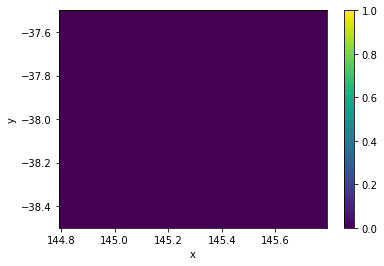

Loading data


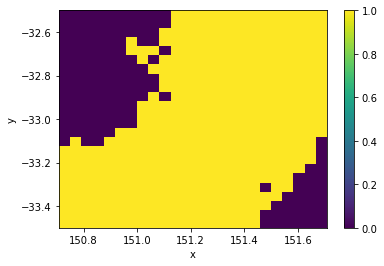

Loading data


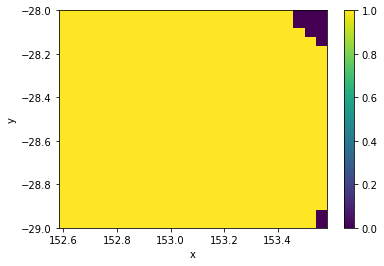

Loading data


In [ ]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], time_slice=time_slice, assets=assets)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [ ]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [ ]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_LX_10.csv', index=None)

### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a region different to Greater Sydney, or even on multiple regions.

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitat of the species of interest. Happy frogging!

In [ ]:
df = pd.read_csv('challenge_1_submission_LX_10.csv')
df_benchmark = pd.read_csv('challenge_1_submission_benchmark.csv')

In [ ]:
(df != df_benchmark)['occurrenceStatus'].sum()

In [ ]:
df_other = pd.read_csv('challenge_1_submission_LX_9.csv')

In [ ]:
(df != df_other)['occurrenceStatus'].sum()